# Pairs Trading

In [1]:
%run ../Code_Imports/Sig_transform_PK.ipynb import *
%run ../Code_Imports/WangZhengStationarisedIndicators.ipynb import *

In [2]:
import matplotlib.pyplot as plt

### 1) Load Dataset

In [3]:
Dataset_CSV_Directories = {'Commods': '../Datasets/ChineseCommodsData_020214_301224.csv', 'Equities': '../Datasets/EUROSTOXX_close_prices_040522_070325.csv', 'FX': '../Datasets/FX_60s_010824_300824.csv'}
Dataset_Datetime_Formats = {'Commods':  '%d/%m/%Y', 'Equities': '%Y-%m-%d %H:%M:%S%z', 'FX': '%d/%m/%Y %H:%M'}

In [4]:
def LoadDataset(AssetClass):
    '''
    AssetClass is in ['Commods', 'Equities', 'FX']
    '''
    # store raw prices
    df_raw = pd.read_csv(Dataset_CSV_Directories[AssetClass]).set_index('Datetime')
    df_raw.index = pd.to_datetime(df_raw.index, format=Dataset_Datetime_Formats[AssetClass])
    df_log = np.log(df_raw)
    
    return df_raw, df_log

In [5]:
def CreateTotalFeatureSet(asset_names, df_raw, df_log, indicators, sig_windows, max_trunc_level):
    '''
    Given the total df (raw and log), pick out asset-pair and generate all technical indicator features and signature features
    '''
    # extract just asset data and its logarithm
    df_asset_raw, df_asset_log = df_raw.loc[:, asset_names], df_log.loc[:, asset_names]

    df_cols = {'raw_price1': df_asset_raw.iloc[:, 0], 'raw_price2': df_asset_raw.iloc[:, 1], 'log_price1': df_asset_log.iloc[:, 0], 'log_price2': df_asset_log.iloc[:, 1]}
    
    # compute technical indicators for given parameters
    for i, asset in enumerate(asset_names):
        for indicator, parameters in indicators:
            df_cols[f'asset_{i+1}_'+indicator+str(parameters)] = StationarisedIndicator(df_asset_raw.iloc[:, i], indicator, parameters)
        df_ret = pd.concat(df_cols, axis=1)
    
    # dimensionality of time-augmented Signature output
    M = sum([3**i for i in range(1, max_trunc_level+1)])

    # compute signature indicators
    for window in sig_windows:
        sig_col_names = [f'sig_window_{window}_{i}' for i in range(1, M + 1)]

        path = df_asset_log.to_numpy().T
        slidsig = SlidingWindowSignature(path, window=window, trunc_level=max_trunc_level, time_aug=True)

        df_sig = pd.DataFrame(slidsig.T, columns=sig_col_names)
        df_ret = pd.concat([df_ret, df_sig.set_index(df_ret.index)], axis=1)
        
    # drop rows so that some features do not generate larger datasets than others (different observation periods)
    df_ret.dropna(inplace=True)
    
    return df_ret

In [6]:
asset_class = 'Equities'

df_raw, df_log = LoadDataset(asset_class)

asset_names = df_raw.columns[:2]

df_features = CreateTotalFeatureSet(asset_names, df_raw, df_log, indicators=[('MA', [4])], sig_windows=[5], max_trunc_level=4)

In [7]:
df_features

,raw_price1,raw_price2,log_price1,log_price2,asset_1_MA[4],asset_2_MA[4],sig_window_5_1,sig_window_5_2,sig_window_5_3,sig_window_5_4,...,sig_window_5_111,sig_window_5_112,sig_window_5_113,sig_window_5_114,sig_window_5_115,sig_window_5_116,sig_window_5_117,sig_window_5_118,sig_window_5_119,sig_window_5_120
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-05-04 11:00:00+00:00,602.400024,94.290001,6.400922,4.546375,0.997385,0.999920,0.001994,-0.002436,4.0,1.988095e-06,...,-0.014251,0.000041,0.000022,0.013526,-0.000011,0.000004,-0.005744,0.023666,0.006187,10.666667
2022-05-04 12:00:00+00:00,601.200012,94.320000,6.398928,4.546693,0.999418,0.999231,0.000166,-0.001483,4.0,1.384594e-08,...,-0.005228,0.000010,0.000010,0.013331,-0.000008,0.000003,0.004104,-0.006604,0.005233,10.666667
2022-05-04 13:00:00+00:00,600.000000,94.059998,6.396930,4.543933,1.002000,1.001621,0.002336,-0.001487,4.0,2.728683e-06,...,0.004102,0.000021,0.000026,-0.006720,0.000008,0.000016,-0.003118,-0.018543,-0.018546,10.666667
2022-05-04 14:00:00+00:00,596.700012,93.730003,6.391414,4.540418,1.005656,1.003947,-0.007513,-0.004790,4.0,2.822396e-05,...,-0.004906,0.000142,0.000096,-0.028957,0.000105,0.000072,-0.020828,-0.046789,-0.032855,10.666667
2022-05-04 15:00:00+00:00,594.799988,93.510002,6.388225,4.538068,1.005674,1.004224,-0.012697,-0.008307,4.0,8.060085e-05,...,-0.022733,0.000152,0.000108,-0.040609,0.000113,0.000080,-0.030056,-0.039524,-0.028365,10.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-07 12:00:00+00:00,637.500000,256.649994,6.457554,5.547713,1.002275,1.004822,0.005505,-0.000390,4.0,1.515429e-05,...,0.014202,0.000019,0.000038,-0.009980,0.000030,0.000112,-0.013178,-0.012348,-0.047735,10.666667
2025-03-07 13:00:00+00:00,633.599976,256.850006,6.451418,5.548492,1.005051,1.002677,-0.013482,-0.005436,4.0,9.088214e-05,...,-0.015912,0.000139,-0.000007,-0.024048,0.000131,0.000045,-0.027067,-0.048878,-0.012361,10.666667
2025-03-07 14:00:00+00:00,632.900024,257.100006,6.450312,5.549465,1.004385,1.000583,-0.007085,-0.004463,4.0,2.509840e-05,...,-0.026540,0.000091,-0.000028,-0.035102,0.000050,0.000013,-0.012402,-0.025770,0.004981,10.666667


In [8]:
from sklearn.model_selection import train_test_split

def CreateTrainTestVal(df, feature_set, train_test_val_split):
    
    X, y = df.loc[:, feature_set].to_numpy(), df.loc[:, 'forecast_label'].to_numpy()

    # split data into train-test-val
    train_size, test_size, val_size = train_test_val_split  # 70% training

    # First, split into training and temp (validation + test)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(val_size + test_size), shuffle=False)
    # Then, split temp into validation and test
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=val_size/(test_size + val_size), shuffle=False)
    
    return X_train, X_test, X_val, y_train, y_test, y_val

In [9]:
import random
import tensorflow as tf
import os

def set_random_seed(seed=42):
    """
    Fixes the random seed across TensorFlow, NumPy, Python's random module, and OS-level randomness.
    """
    random.seed(seed)  # Python's built-in random module
    np.random.seed(seed)  # NumPy
    tf.random.set_seed(seed)  # TensorFlow/Keras
    
    # Ensure TensorFlow does not introduce randomness due to parallel execution
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # Ensures deterministic CuDNN operations (if using GPU)

In [10]:
def reshape_for_lstm(data, timesteps):
    samples = data.shape[0] - timesteps + 1
    return np.array([data[i:i+timesteps] for i in range(samples)])

In [11]:
# global lstm param variable
LSTM_TIMESTEPS = 10

In [12]:
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint


def FitAndPredictModel(model_type, X_train, y_train, X_test, y_test):
    
    set_random_seed()
    # Define models in dictionary
    model_map = {
        'XGB': xgb.XGBClassifier(objective="binary:logistic", n_estimators=200),
        
        'LogReg': LogisticRegression(solver='lbfgs'),

        'FeedForward': Sequential([
            tf.keras.Input(shape=(X_train.shape[1],)),  # Use Input instead of input_shape in Dense
            Dense(64),  
            Dense(20, activation='relu'),
            Dropout(0.3),
            Dense(10, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='sigmoid')]),

        'LSTM': Sequential([
            tf.keras.Input(shape=(LSTM_TIMESTEPS, X_train.shape[1])),  # Use Input instead of input_shape in LSTM
            LSTM(32, activation='relu', return_sequences=True),
            Dropout(0.3),
            LSTM(20, activation='relu', return_sequences=False),
            Dropout(0.3),
            Dense(1, activation='sigmoid')  # Output layer for binary classification
        ]) 
    }

    model = model_map[model_type]
    
    # scale inputs
    # Apply Expanding Window Scaler
    scaler = IdentityScaler()
    #scaler = ExpandingWindowScaler(min_periods=5)  # Start normalizing after 5 observations
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    if model_type in ['XGB', 'LogReg']:
        # fit model
        model.fit(X_train, y_train)        
        y_outsample_pred = model.predict(X_test)
    
    if model_type == 'FeedForward':
        # Compile the model
        model.compile(optimizer=Adam(learning_rate=0.001),  # Initial learning rate
                      loss=BinaryCrossentropy(),
                      metrics=['accuracy'])

        # Callbacks
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0)
        model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=0)

        # Train the model
        history = model.fit(X_train, y_train, 
                            epochs=25, batch_size=128, 
                            validation_data=(X_test, y_test), 
                            callbacks=[lr_scheduler, model_checkpoint], verbose=0)

        # Load the best model
        model = tf.keras.models.load_model('best_model.keras')
        
        # Convert probabilities to class predictions (threshold = 0.5)
        y_outsample_pred_prob = model.predict(X_test, verbose=0)

        # Apply threshold to get binary class predictions
        y_outsample_pred = (y_outsample_pred_prob > 0.5).astype(int)
        
    if model_type == 'LSTM':
        
        # Reshape data for LSTM (samples, timesteps, features)
        X_train_lstm = reshape_for_lstm(X_train, LSTM_TIMESTEPS)
        X_test_lstm = reshape_for_lstm(X_test, LSTM_TIMESTEPS)

        # Adjust y labels to match reshaped sequences
        y_train_lstm = y_train[LSTM_TIMESTEPS - 1:]
        y_test_lstm = y_test[LSTM_TIMESTEPS - 1:]

        # Compile the model
        model.compile(optimizer=Adam(learning_rate=0.001),  # Initial learning rate
                      loss=BinaryCrossentropy(),
                      metrics=['accuracy'])

        # Callbacks
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0)
        model_checkpoint = ModelCheckpoint('best_lstm_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=0)

        # Train the model
        history = model.fit(X_train_lstm, y_train_lstm, 
                            epochs=20, batch_size=128, 
                            validation_data=(X_test_lstm, y_test_lstm), 
                            callbacks=[lr_scheduler, model_checkpoint], verbose=0)

        # Load the best model
        model = tf.keras.models.load_model('best_lstm_model.keras')

        # Convert probabilities to class predictions (threshold = 0.5)
        y_outsample_pred_prob = model.predict(X_test_lstm, verbose=0)

        # Apply threshold to get binary class predictions
        y_outsample_pred = (y_outsample_pred_prob > 0.5).astype(int) 
        
        # replace generic y_test with shape-modified y_test
        y_test = y_test_lstm
    
    # evalute test accuracy
    outsample_accuracy = accuracy_score(y_outsample_pred, y_test)
    
    return (model, scaler, outsample_accuracy)


In [13]:
def SelectBestModelAndPredict(ResultsDict, X_val_dict):
    """
    Selects the best model for each feature set based on test accuracy and 
    predicts on the validation set.

    Parameters:
        ResultsDict (dict): A dictionary containing trained models, scalers, and accuracy scores.
        X_val_dict (dict): A dictionary containing validation feature sets.

    Returns:
        dict: A dictionary containing predictions on the validation set for each feature set.
    """
    best_models = {}
    val_predictions = {}

    for feature_set_name, models in ResultsDict.items():
        # Find the best model (highest accuracy)
        best_model_name = max(models, key=lambda model: models[model][2])  # Third element is accuracy
        best_model, best_scaler, best_accuracy = models[best_model_name]

        # Retrieve validation data
        X_val = X_val_dict[feature_set_name]

        # Apply scaling if necessary
        if best_scaler is not None:
            X_val_scaled = best_scaler.transform(X_val)
        else:
            X_val_scaled = X_val
            
        # reshape if LSTM model
        if best_model_name == 'LSTM':
            print('LSTM IS BEST!')
            X_val_scaled = reshape_for_lstm(X_val_scaled, LSTM_TIMESTEPS)

        # Generate predictions
        y_val_pred = (best_model.predict(X_val_scaled) > 0.5).astype("int32")

        # Store results
        best_models[feature_set_name] = (best_model_name, best_accuracy)
        val_predictions[feature_set_name] = y_val_pred

    return best_models, val_predictions

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

class ExpandingWindowScaler(BaseEstimator, TransformerMixin):
    def __init__(self, min_periods=10):
        """
        Expanding window scaler with controlled information leakage for early observations.
        
        Parameters:
        - min_periods (int): Number of observations before switching to pure expanding window.
        """
        self.min_periods = min_periods
        self.global_mean = None
        self.global_std = None

    def fit(self, X, y=None):
        """Computes the global mean and std based on the first `min_periods` observations."""
        X = np.asarray(X).flatten()
        self.global_mean = np.mean(X[:self.min_periods])
        self.global_std = np.std(X[:self.min_periods]) if np.std(X[:self.min_periods]) > 0 else 1
        return self

    def transform(self, X):
        """Applies standardization with global stats for early values and expanding stats afterward."""
        X = pd.DataFrame(X)  # Ensure it's a DataFrame for expanding operations
        expanding_mean = X.expanding(min_periods=self.min_periods).mean()
        expanding_std = X.expanding(min_periods=self.min_periods).std()

        # Use global mean & std for first `min_periods` observations
        X_scaled = (X - expanding_mean) / (expanding_std + 1e-8)
        X_scaled.iloc[:self.min_periods] = (X.iloc[:self.min_periods] - self.global_mean) / self.global_std
        
        return X_scaled.values

    def fit_transform(self, X, y=None):
        """Fits and transforms in one step."""
        self.fit(X)
        return self.transform(X)


class IdentityScaler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X

In [15]:
def TrainModels(df_features, indicators_col_names, sig_col_names, forecast_tau, forecast_threshold=0):

    df_classification = df_features.copy()
    df_classification['forecast_return'] =  (-df_classification.log_price1.diff(-forecast_tau)) - (-df_classification.log_price2.diff(-forecast_tau))

    # for classification tasks, classes are labelled 0, 1 (0 is short and 1 is long)
    df_classification['forecast_label'] = np.where(df_classification.forecast_return > 0, 1, 0)

    feature_sets = [(indicators_col_names, 'TI'), (sig_col_names, 'Sig'), (indicators_col_names + sig_col_names, 'TI_and_Sig')]
    ResultsDict = {'TI':{}, 'Sig':{}, 'TI_and_Sig':{}}
    model_types = ['FeedForward', 'LSTM', 'XGB', 'LogReg']
    
    X_val_dict = {}
    y_val_dict = {}

    for feature_set, feature_set_name in feature_sets:

        #print(f'features used: {feature_set_name}', '-'*40)

        # extract correct feature set and classification labels
        X_train, X_test, X_val, y_train, y_test, y_val = CreateTrainTestVal(df_classification, feature_set, train_test_val_split)
        
        X_val_dict[feature_set_name] = X_val
        y_val_dict[feature_set_name] = y_val
        
        for model_type in model_types:
            # fit models 

            #print(f'training {model_type}...')
            ResultsDict[feature_set_name][model_type] = FitAndPredictModel(model_type, X_train, y_train, X_test, y_test)
    
    # pick the best model for each feature_set and plot the validation backtest...
    best_models, val_predictions = SelectBestModelAndPredict(ResultsDict, X_val_dict)
    #print('done!')
    
    # Calculate accuracy on validation set
#     val_accuracies = {
#         feature_set: accuracy_score(y_val_dict[feature_set], val_predictions[feature_set])
#         for feature_set in val_predictions
#     }
    val_accuracies = {}
    for feature_set in val_predictions:
        if best_models[feature_set][0] == 'LSTM':
            y_val_dict[feature_set] = y_val_dict[feature_set][LSTM_TIMESTEPS - 1:]
        
        val_accuracies[feature_set] = accuracy_score(y_val_dict[feature_set], val_predictions[feature_set])
    

    print("Validation Accuracy Scores:", val_accuracies)
    
    for feature_set in val_predictions:
        df_classification[feature_set+'_preds'] = np.nan
        
        y_preds = val_predictions[feature_set]
        if len(y_preds.shape) == 2:
            y_preds = y_preds.squeeze()
        
        
        df_classification.loc[df_classification.index[-len(y_preds):], feature_set+'_preds'] = y_preds

    
    return ResultsDict, df_classification, best_models

In [16]:
import matplotlib.pyplot as plt
def PlotValidationPnL(df_val_pnl):

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 4))

    # Plot the data
    (100 * df_val_pnl.loc[:, ['TI_Cum_PnL', 'Sig_Cum_PnL', 'TI_and_Sig_Cum_PnL']]).plot(ax=ax)

    # Customization
    ax.set_facecolor("#f0f0f0")  # Light grey background
    fig.patch.set_facecolor("#f0f0f0")  # Set figure background

    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)  # Gridlines
    ax.spines['top'].set_visible(False)  # Hide top spine
    ax.spines['right'].set_visible(False)  # Hide right spine

    # Set labels and title
    ax.set_ylabel("Cumulative PnL (%)")
    ax.set_title("Performance Comparison", fontsize=14, fontweight='bold')

    # Custom legend
    ax.legend(['CI', 'RTAS', 'CI + RTAS'], fontsize=10)

    # Show the plot
    plt.show()

In [17]:
# 10

n = 20 # roughly same no. of non sig indicators...
m = 10
k = 5
sig_windows = [20]

technical_indicators = ['EMA', 'BB', 'ROC', 'RSI']
indicators = [(TI, [n]) for TI in technical_indicators] + [('MACD', [m, n, k])]

max_trunc_level = 3

In [18]:
indicators_col_names = [f'asset_{i}_' + x + str(y) for x,y in indicators for i in [1,2]]

M = sum([3**i for i in range(1, max_trunc_level+1)])
sig_col_names = [f'sig_window_{window}_{i}' for i in range(1, M + 1) for window in sig_windows]

forecast_tau = 1
forecast_threshold = 0
train_test_val_split = [0.5, 0.3, 0.2]

In [19]:
def ExtractNMostCorrelatedPairs(df, N):
    
    # Assuming df is your DataFrame with asset log prices
    log_returns = df.diff().dropna()  # Compute log returns
    corr_matrix = log_returns.corr().abs()  # Compute absolute correlation matrix

    # Mask the upper triangle and diagonal
    mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    masked_corr = corr_matrix.where(mask)

    # Unstack, sort, and get top 20 pairs with their correlations
    top_pairs = masked_corr.unstack().dropna().sort_values(ascending=False).head(N)

    # Convert to list of tuples: ([asset1, asset2], correlation)
    most_correlated_pairs = [([a, b], corr) for (a, b), corr in top_pairs.items()]

    return most_correlated_pairs

In [20]:
import pickle

for AssetClass in ['FX']:
    print(AssetClass)
    
    # initialise list containing all the trading metrics for each asset-class
    trading_metrics = []
    
    best_model_list = []
    
    df_total_raw, df_total_log = LoadDataset(AssetClass)
    # number of pairs to test
    N = 20
    most_correlated_pairs = ExtractNMostCorrelatedPairs(df_total_log, N)
    
    
    # iterate through every asset_name
    for i in range(N):
        try:
            # --------------------------------------------------------
            asset_names, corr = most_correlated_pairs[i]
            print(f'pair={asset_names}, corr={corr}')

            # --------------------------------------------------------
            # this creates all the features we might be interested in experimenting with
            df_features = CreateTotalFeatureSet(asset_names, df_total_raw, df_total_log, indicators, sig_windows, max_trunc_level)
            # -------------------------------------------------------
            ResultsDict, df_classification, best_models = TrainModels(df_features, indicators_col_names, sig_col_names, forecast_tau, forecast_threshold=0)
            
            best_model_list.append(best_models)
            
            # compute PnL on Validation Set
            df_val_pnl = df_classification.dropna().copy()
            for feature_set in ['TI', 'Sig', 'TI_and_Sig']:

                df_val_pnl[feature_set + '_PnL'] = np.power(-1, 1 + df_val_pnl.loc[:, feature_set+'_preds'])*df_val_pnl.forecast_return
                df_val_pnl[feature_set + '_Cum_PnL'] = np.exp(df_val_pnl[feature_set + '_PnL'].cumsum())
            # Visualise
            PlotValidationPnL(df_val_pnl)
            
            trading_metrics.append([compute_performance_metrics(df_val_pnl, pnl_col=col) for col in ['TI_PnL', 'Sig_PnL', 'TI_and_Sig_PnL']])
            print(trading_metrics[-1])
            
        except Exception as e:
            #Handle the error
            print(f"An error occurred: {e}")
            
    with open(f'TradingMetricsList_{AssetClass}.pkl', 'wb') as f:
        pickle.dump(trading_metrics, f)
        
    with open(f'BestModelsList_{AssetClass}.pkl', 'wb') as f:
        pickle.dump(best_model_list, f)


FX
pair=['GBPUSD', 'EURUSD'], corr=0.695486562443532


KeyboardInterrupt: 

# Process Metrics

In [21]:
def compute_performance_metrics(df, pnl_col='PnL'):
    # Ensure datetime index is sorted
    df = df.sort_index()

    # Determine frequency in days
    dt = (df.index[1] - df.index[0]).total_seconds()
    periods_per_year = {
        'daily': 252,
        'hourly': 252 * 6.5,  # Assuming 6.5 trading hours per day
        'minute': 252 * 6.5 * 60
    }

    if dt >= 86400:
        freq = 'daily'
    elif dt >= 3600:
        freq = 'hourly'
    else:
        freq = 'minute'

    ann_factor = periods_per_year[freq]

    returns = df[pnl_col]

    # Sharpe Ratio
    sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(ann_factor)

    # Sortino Ratio
    downside_returns = returns[returns < 0]
    sortino_denom = downside_returns.std()
    sortino_ratio = (returns.mean() / sortino_denom) * np.sqrt(ann_factor) if sortino_denom != 0 else np.nan

    # Max Drawdown (based on cumulative return)
    cum_returns = np.exp(returns.cumsum())
    running_max = cum_returns.cummax()
    drawdown = cum_returns / running_max - 1
    max_drawdown = drawdown.min()

    # Accuracy (win rate)
    total_trades = len(returns)
    winning_trades = (returns > 0).sum()
    accuracy = winning_trades / total_trades if total_trades > 0 else np.nan

    return {
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Max Drawdown': max_drawdown,
        'Accuracy': accuracy,
        'Frequency': freq
    }


In [22]:
def CleanMetricsAndSummarise(data):

    # Create DataFrame with 3 columns (one per model)
    df = pd.DataFrame(data, columns=['TI', 'Sig', 'TI_and_Sig'])

    # Drop 'Frequency' from each dictionary before expanding
    for col in df.columns:
        df[col] = df[col].apply(lambda d: {k: v for k, v in d.items() if k != 'Frequency'})

    # Expand into a flat DataFrame
    df_expanded = pd.concat([df[col].apply(pd.Series) for col in df.columns], axis=1, keys=df.columns)

    # Flatten column multi-index
    df_expanded.columns = ['_'.join(col).strip() for col in df_expanded.columns.values]
    
    return df_expanded

In [23]:
def PlotBox(df_expanded):

    # Set global high-DPI and style
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['axes.linewidth'] = 1.2

    for metric in ['Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown', 'Accuracy']:
        plt.figure(figsize=(8, 3))

        # Extract relevant columns
        data = df_expanded.filter(like=metric)

        # Custom boxplot with clean black-and-white style
        boxprops = dict(linewidth=1.5, color='black')
        whiskerprops = dict(linewidth=1.2, color='black')
        capprops = dict(linewidth=1.2, color='black')
        medianprops = dict(linewidth=2.0, color='black')
        flierprops = dict(marker='o', markerfacecolor='black', markersize=3, linestyle='none')

        data.boxplot(
            boxprops=boxprops,
            whiskerprops=whiskerprops,
            capprops=capprops,
            medianprops=medianprops,
            flierprops=flierprops
        )

        plt.title(f"{metric} Across Feature-Sets: {AssetClass}", fontsize=12)
        plt.ylabel(metric, fontsize=10)
        plt.xticks([1, 2, 3], ['CI', 'RTAS', 'CI + RTAS'], fontsize=9)
        plt.yticks(fontsize=9)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [24]:
import seaborn as sns
def PlotHist(df_expanded):
    # Set up high-res figure
    plt.figure(figsize=(8, 4), dpi=300)
    plt.rcParams['font.family'] = 'serif'

    # Extract and rename the columns (Sharpe Ratios in this example)
    sharpe_data = df_expanded.filter(like='Sharpe Ratio')
    sharpe_data.columns = ['CI', 'RTAS', 'CI + RTAS']

    # Plot each distribution as a line-only histogram (step style)
    for label, color in zip(sharpe_data.columns, ['tab:blue', 'tab:orange', 'tab:green']):
        plt.hist(
            sharpe_data[label],
            bins=20,
            density=True,
            histtype='step',
            linewidth=1.8,
            label=label,
            color=color
        )

    # Add vertical reference line at 0
    plt.axvline(0, color='black', linestyle='--', linewidth=1)

    # Labels and title
    plt.title("Sharpe Ratio Distributions", fontsize=12, weight='bold')
    plt.xlabel("Sharpe Ratio")
    plt.ylabel("Density")
    plt.legend(frameon=False, fontsize=10)
    plt.tight_layout()
    plt.show()

In [25]:
df_expanded

NameError: name 'df_expanded' is not defined

----------------------------------------------------------------------------------------------------
FX
mean
TI_Sharpe Ratio             16.082814
TI_Sortino Ratio            22.610178
TI_Max Drawdown             -0.005801
TI_Accuracy                  0.525719
Sig_Sharpe Ratio             8.892702
Sig_Sortino Ratio           12.250766
Sig_Max Drawdown            -0.009571
Sig_Accuracy                 0.513971
TI_and_Sig_Sharpe Ratio     16.330041
TI_and_Sig_Sortino Ratio    23.072395
TI_and_Sig_Max Drawdown     -0.005502
TI_and_Sig_Accuracy          0.524908
dtype: float64
median
TI_Sharpe Ratio             17.694369
TI_Sortino Ratio            24.469888
TI_Max Drawdown             -0.005331
TI_Accuracy                  0.527303
Sig_Sharpe Ratio             8.580684
Sig_Sortino Ratio           11.687411
Sig_Max Drawdown            -0.008393
Sig_Accuracy                 0.517118
TI_and_Sig_Sharpe Ratio     18.672443
TI_and_Sig_Sortino Ratio    25.594781
TI_and_Sig_Max Drawdown     -0.00

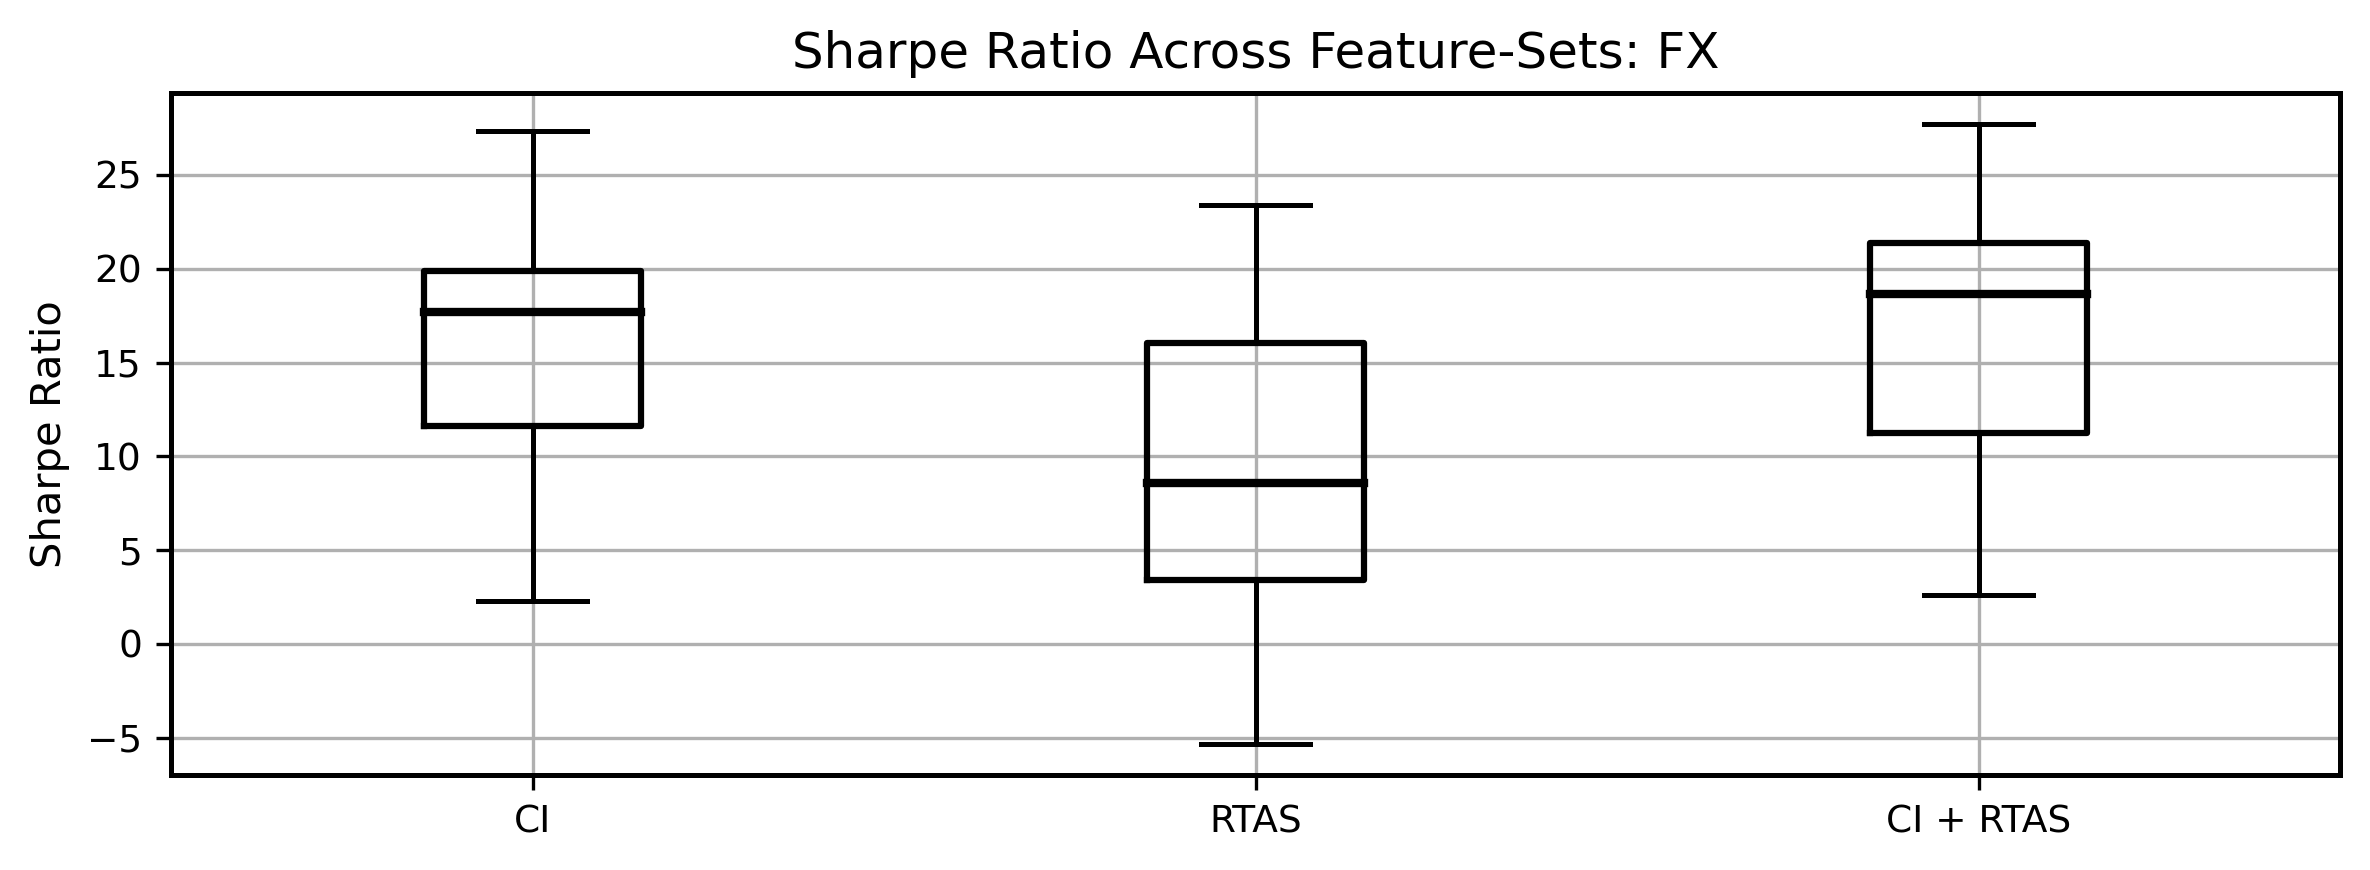

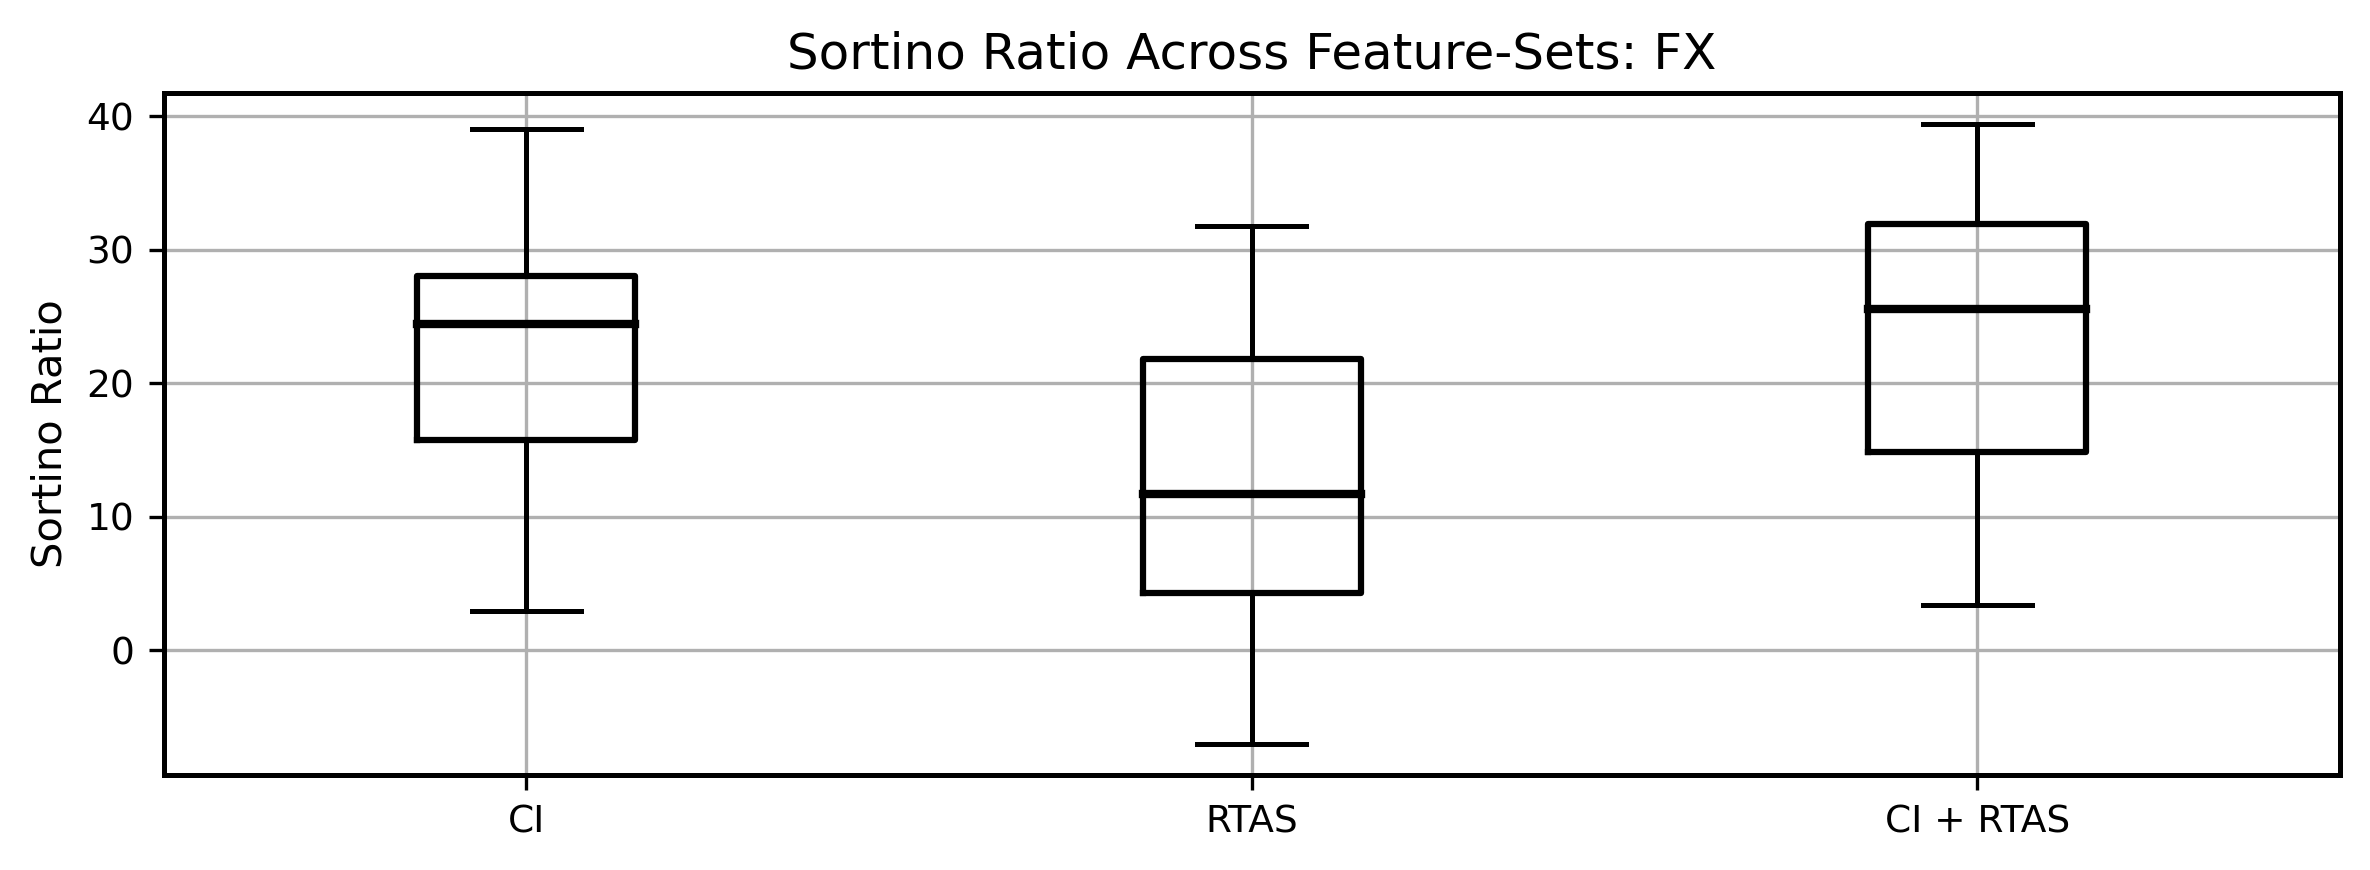

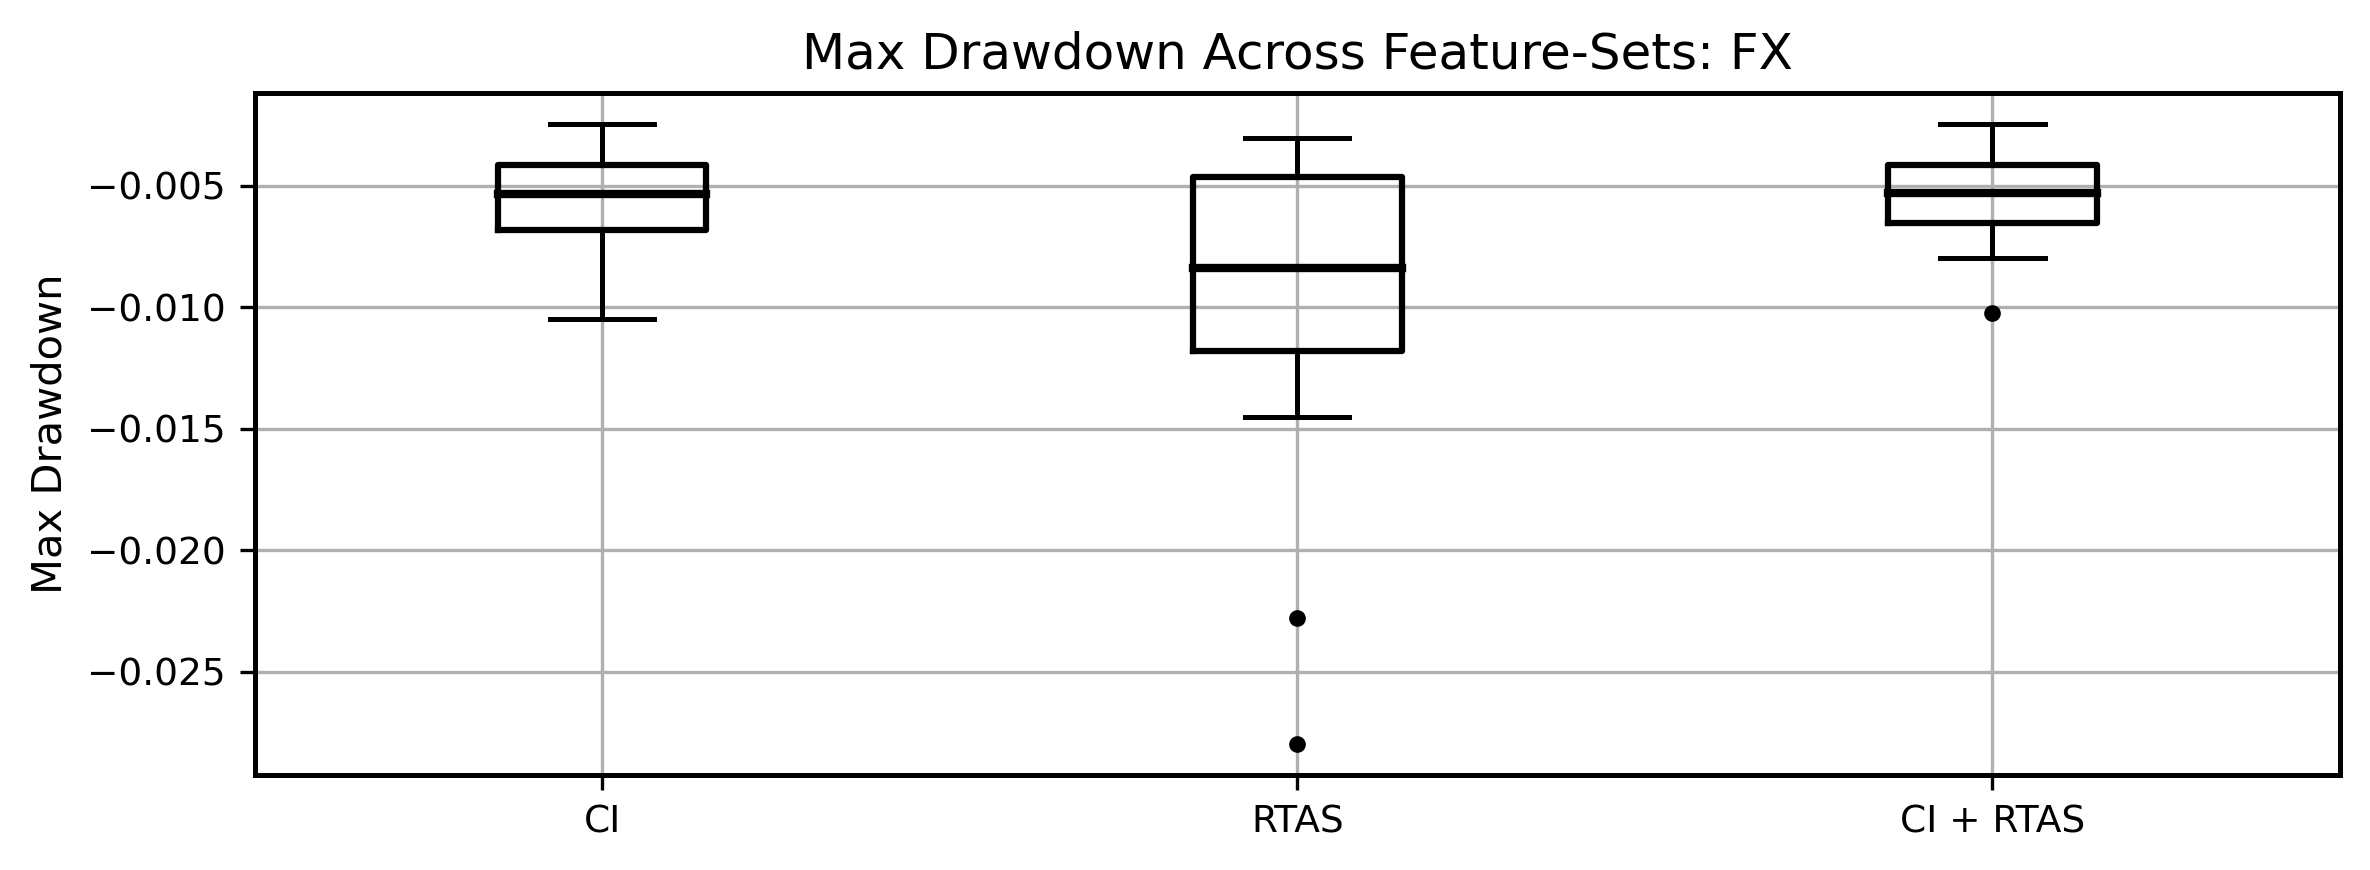

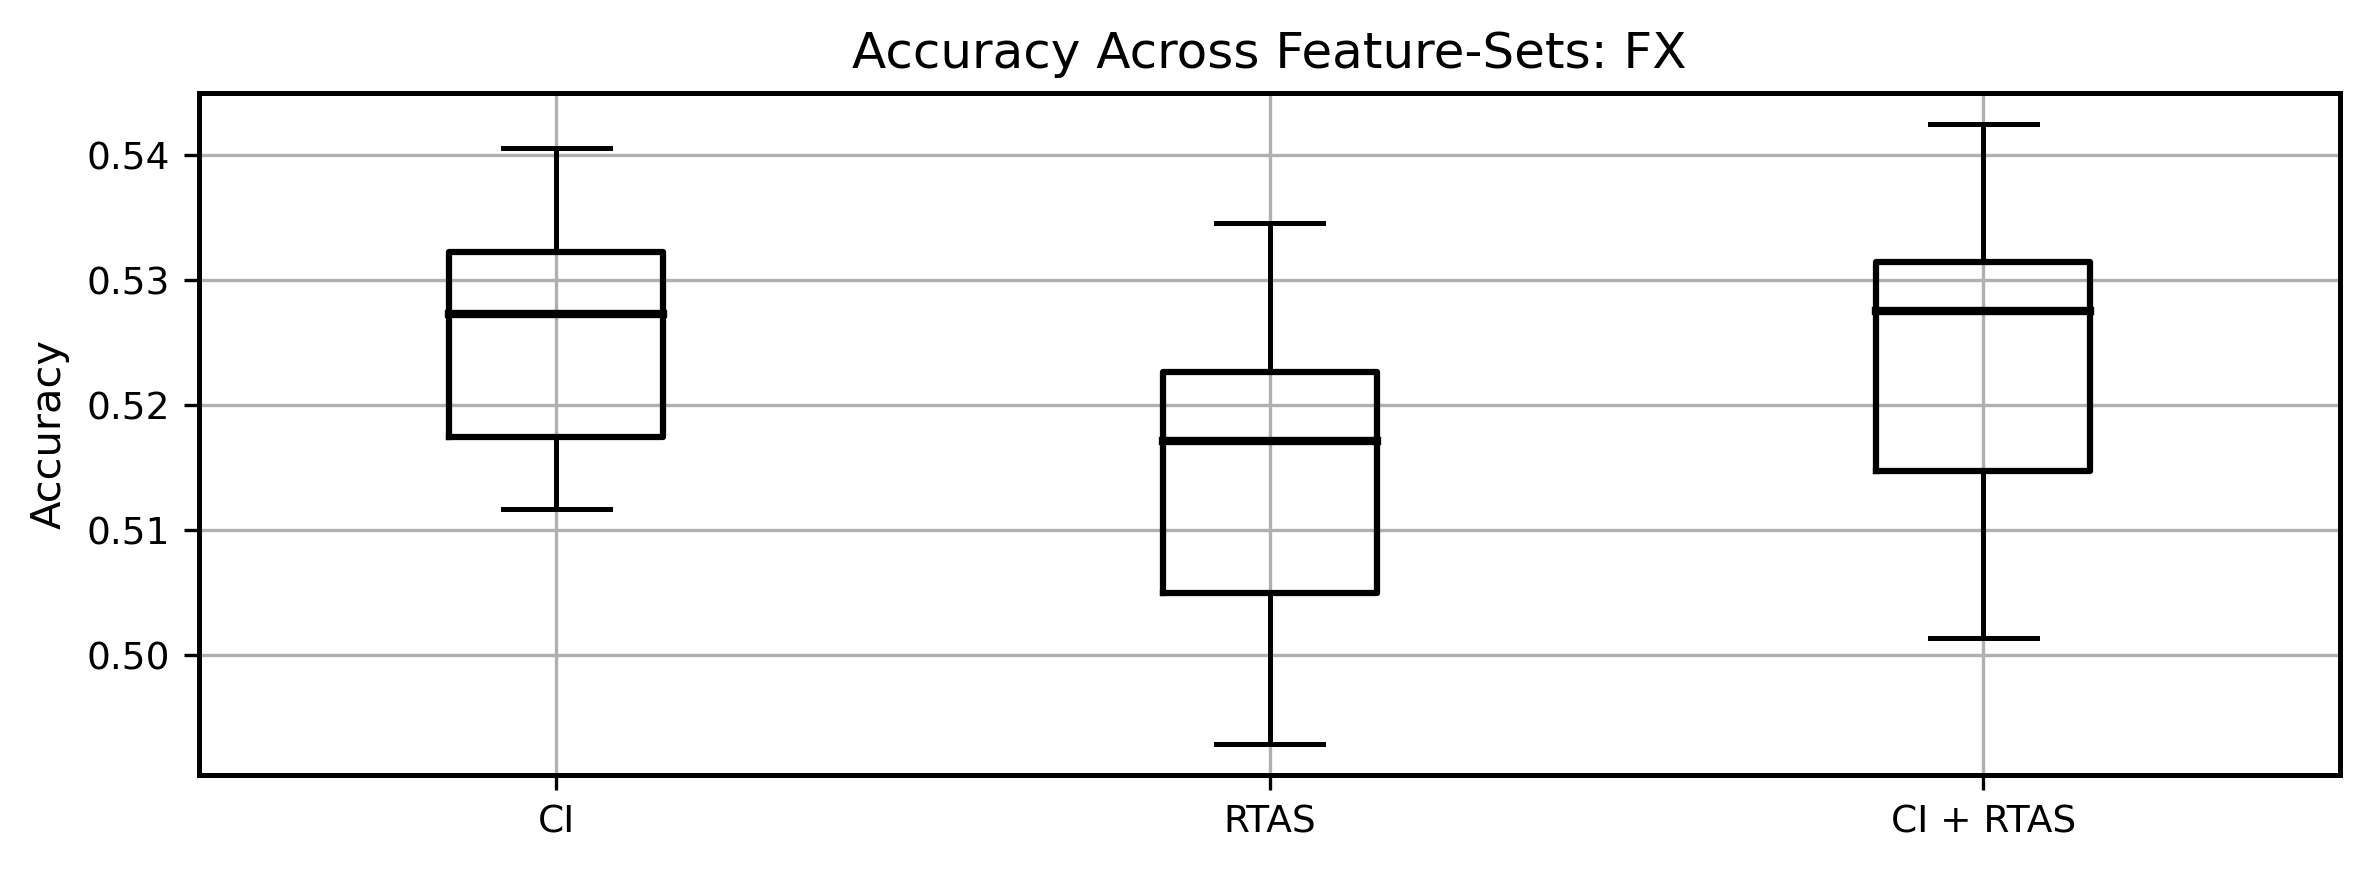

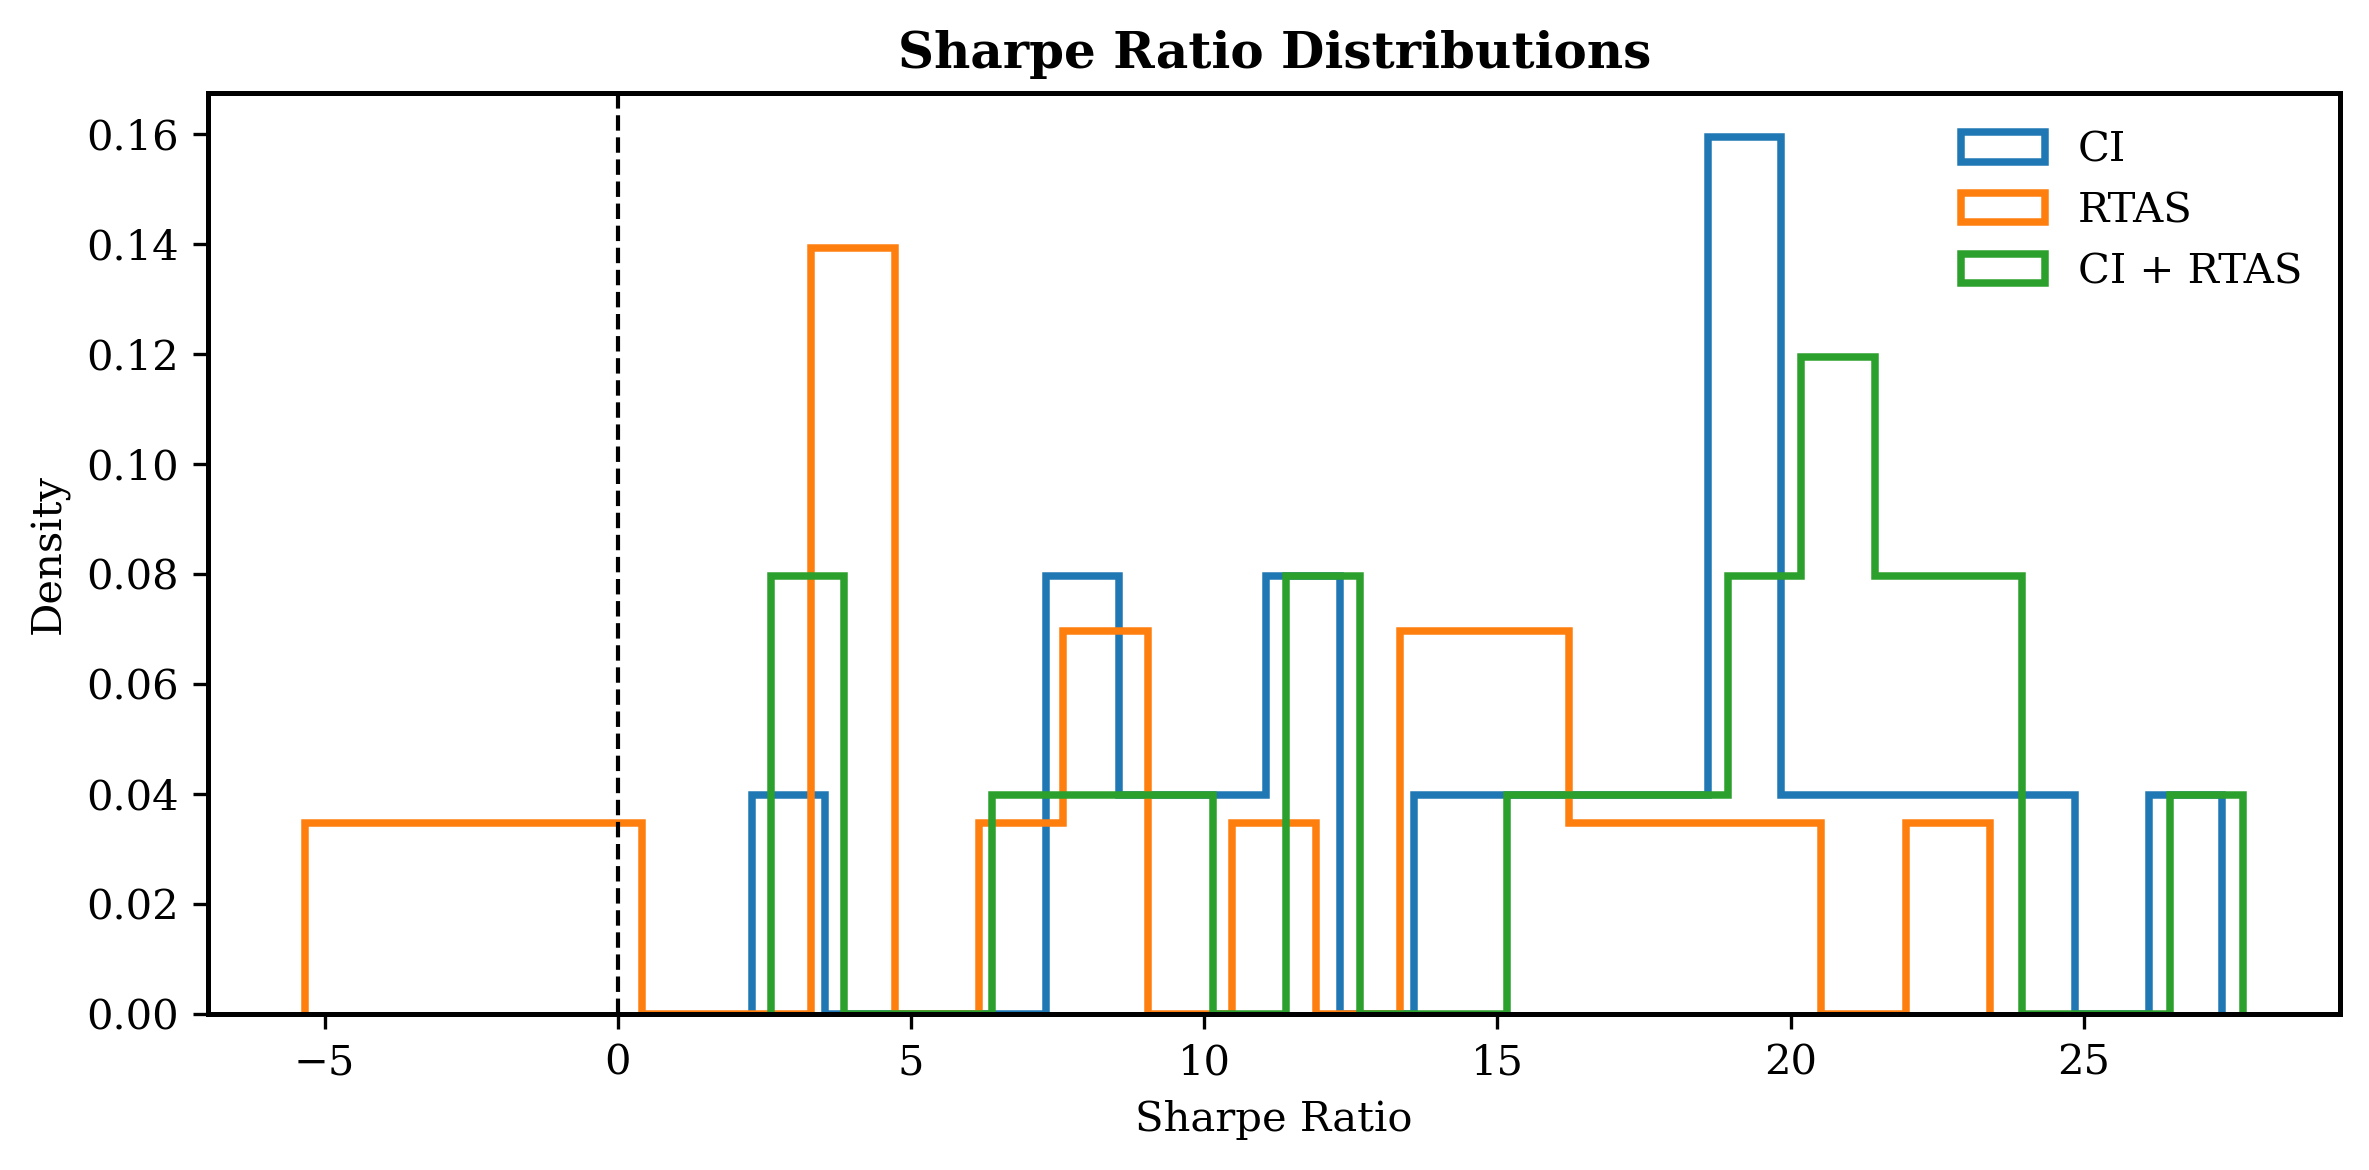

----------------------------------------------------------------------------------------------------
Equities
mean
TI_Sharpe Ratio            -0.037593
TI_Sortino Ratio            0.028716
TI_Max Drawdown            -0.219435
TI_Accuracy                 0.501216
Sig_Sharpe Ratio            0.200093
Sig_Sortino Ratio           0.318180
Sig_Max Drawdown           -0.217071
Sig_Accuracy                0.502483
TI_and_Sig_Sharpe Ratio    -0.091517
TI_and_Sig_Sortino Ratio   -0.053591
TI_and_Sig_Max Drawdown    -0.214107
TI_and_Sig_Accuracy         0.496679
dtype: float64
median
TI_Sharpe Ratio            -0.079610
TI_Sortino Ratio           -0.099884
TI_Max Drawdown            -0.178406
TI_Accuracy                 0.501168
Sig_Sharpe Ratio            0.010532
Sig_Sortino Ratio           0.023288
Sig_Max Drawdown           -0.211477
Sig_Accuracy                0.501754
TI_and_Sig_Sharpe Ratio     0.039922
TI_and_Sig_Sortino Ratio    0.049911
TI_and_Sig_Max Drawdown    -0.189676
TI_and_Sig_A

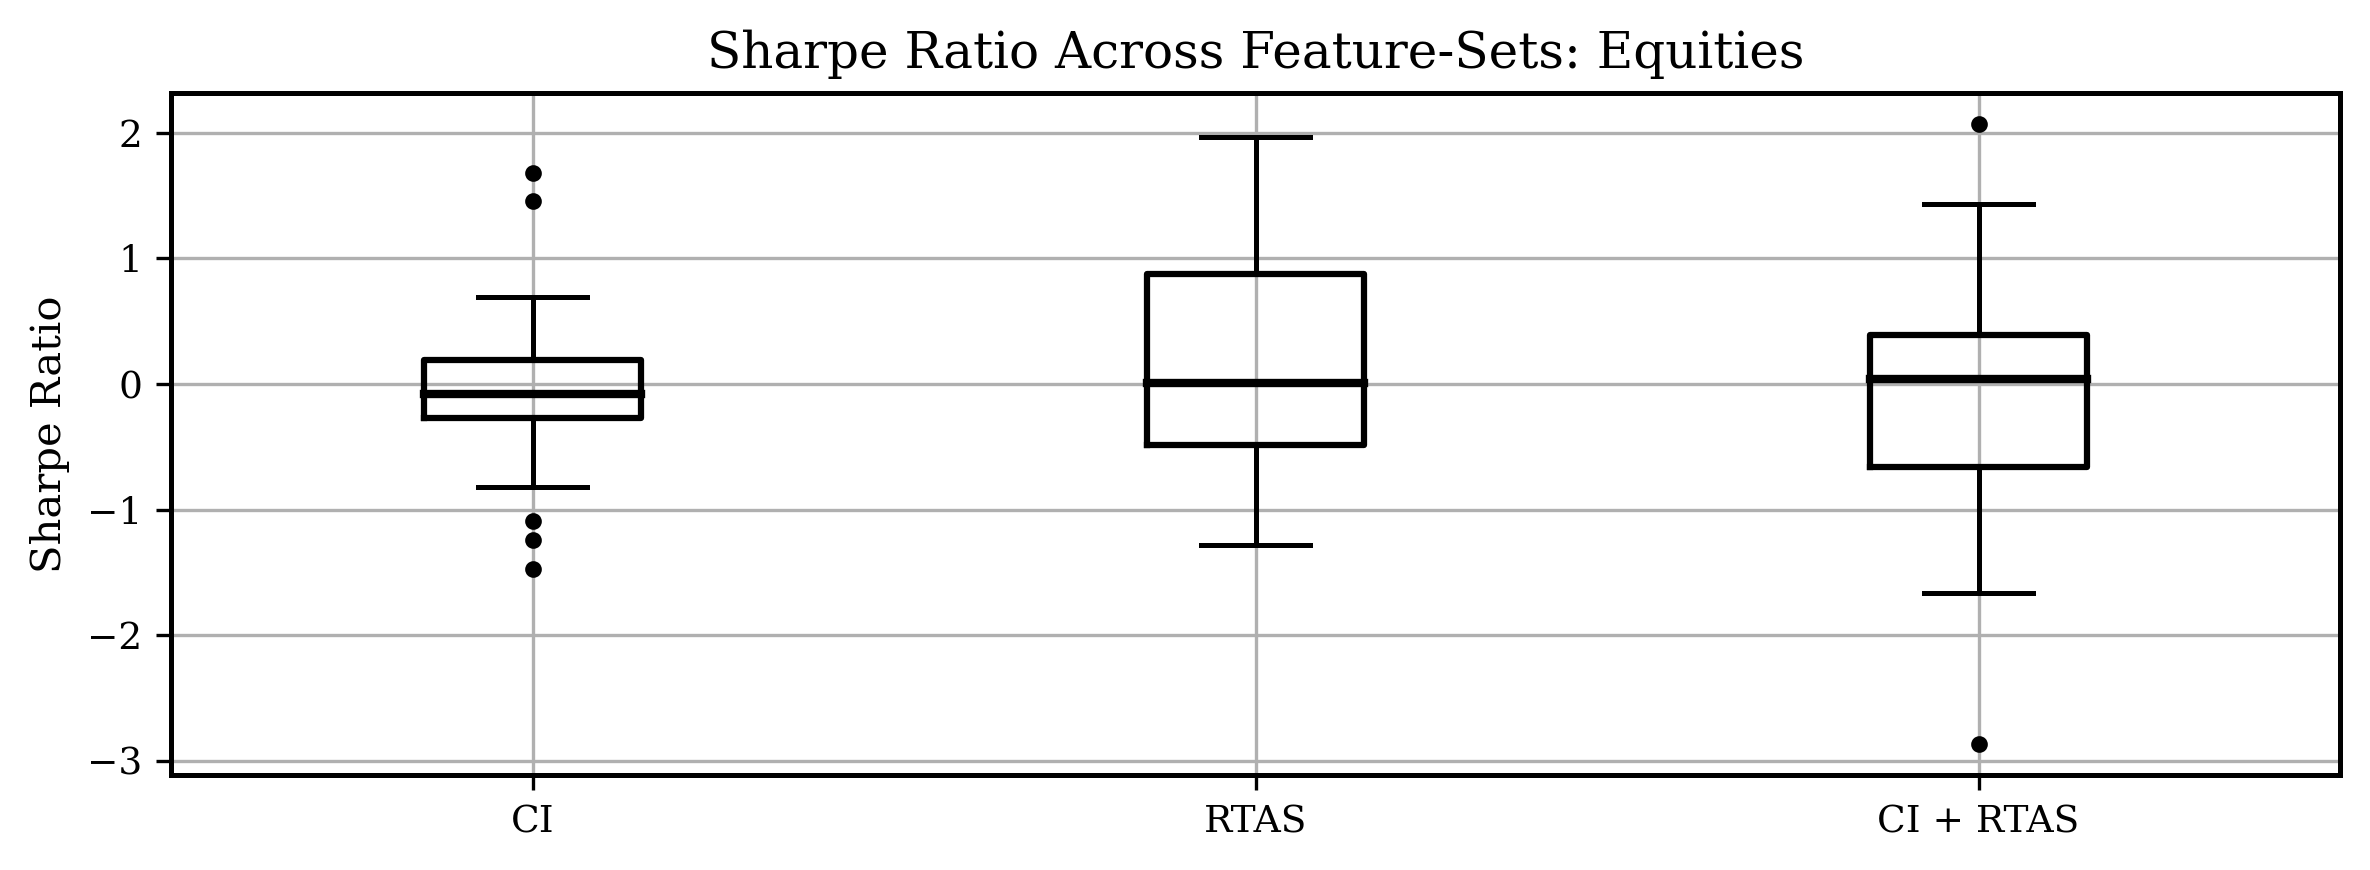

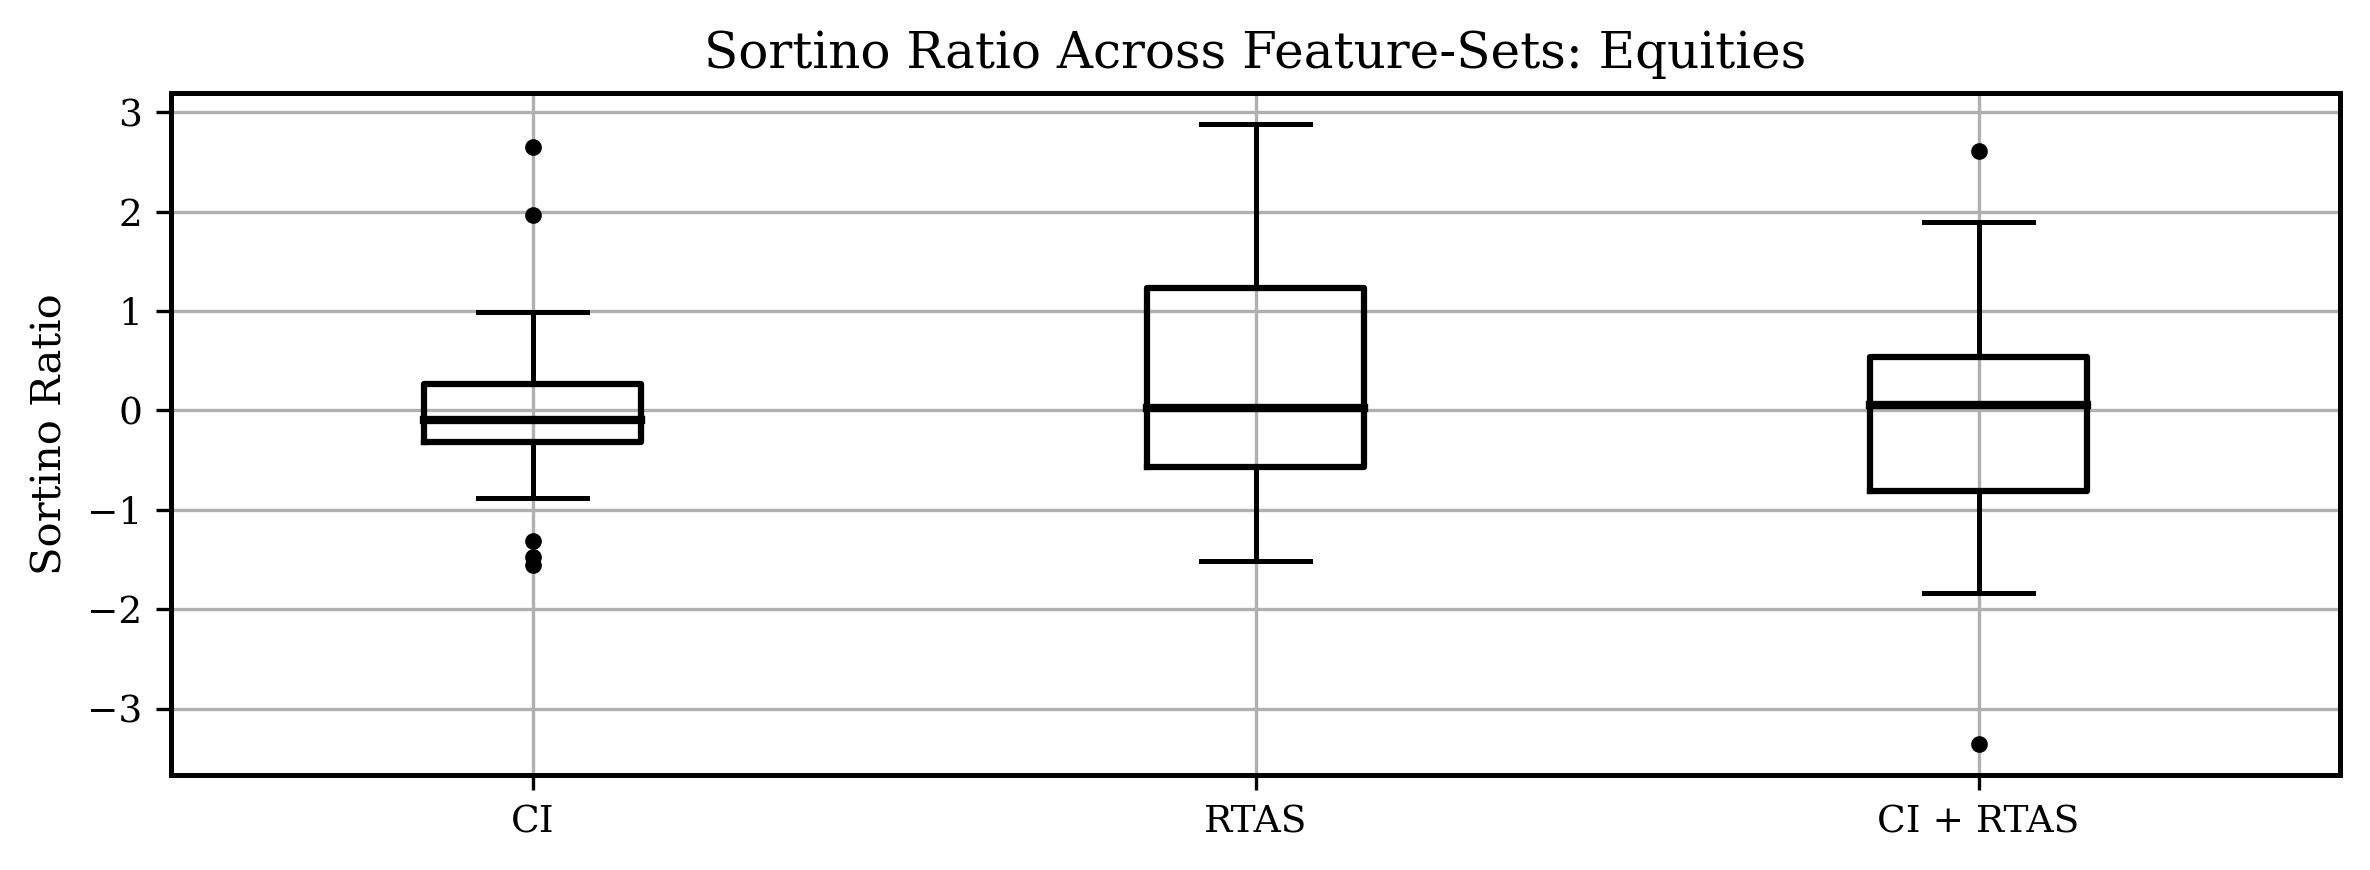

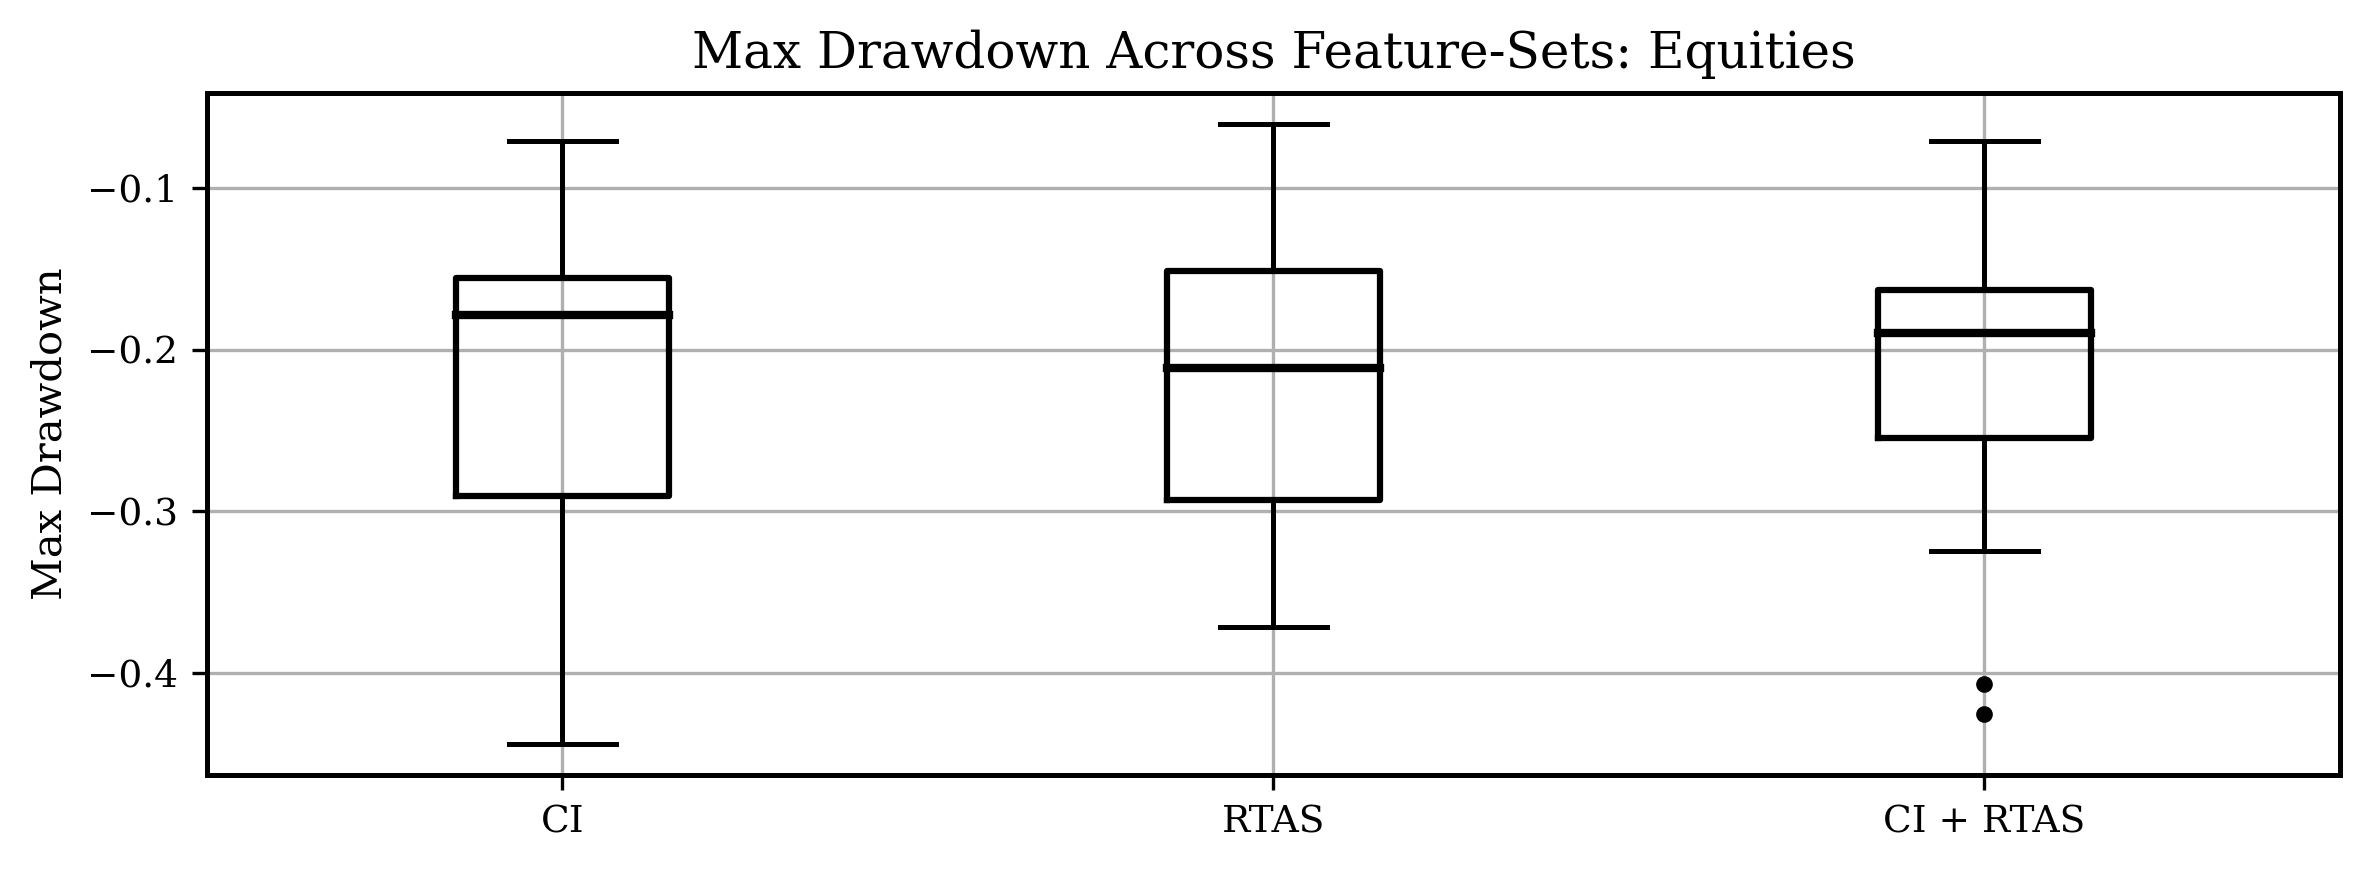

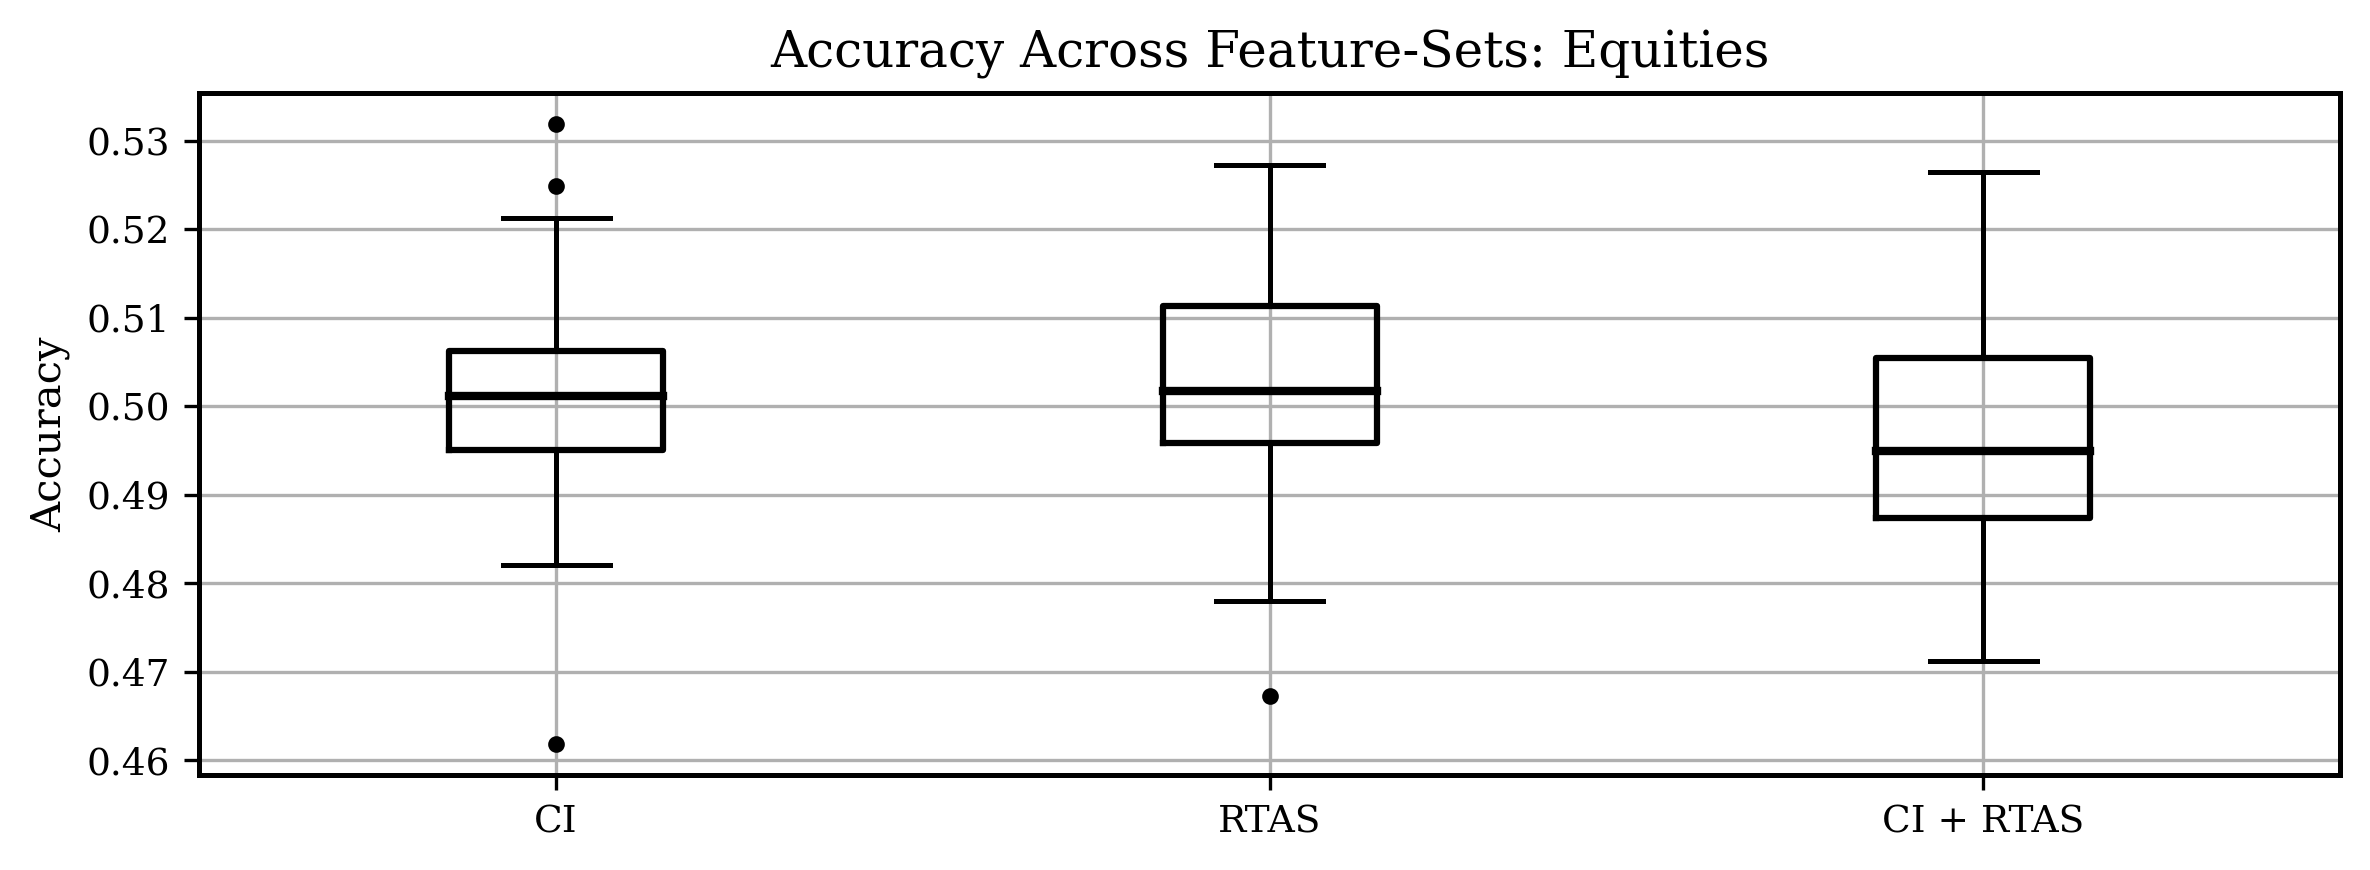

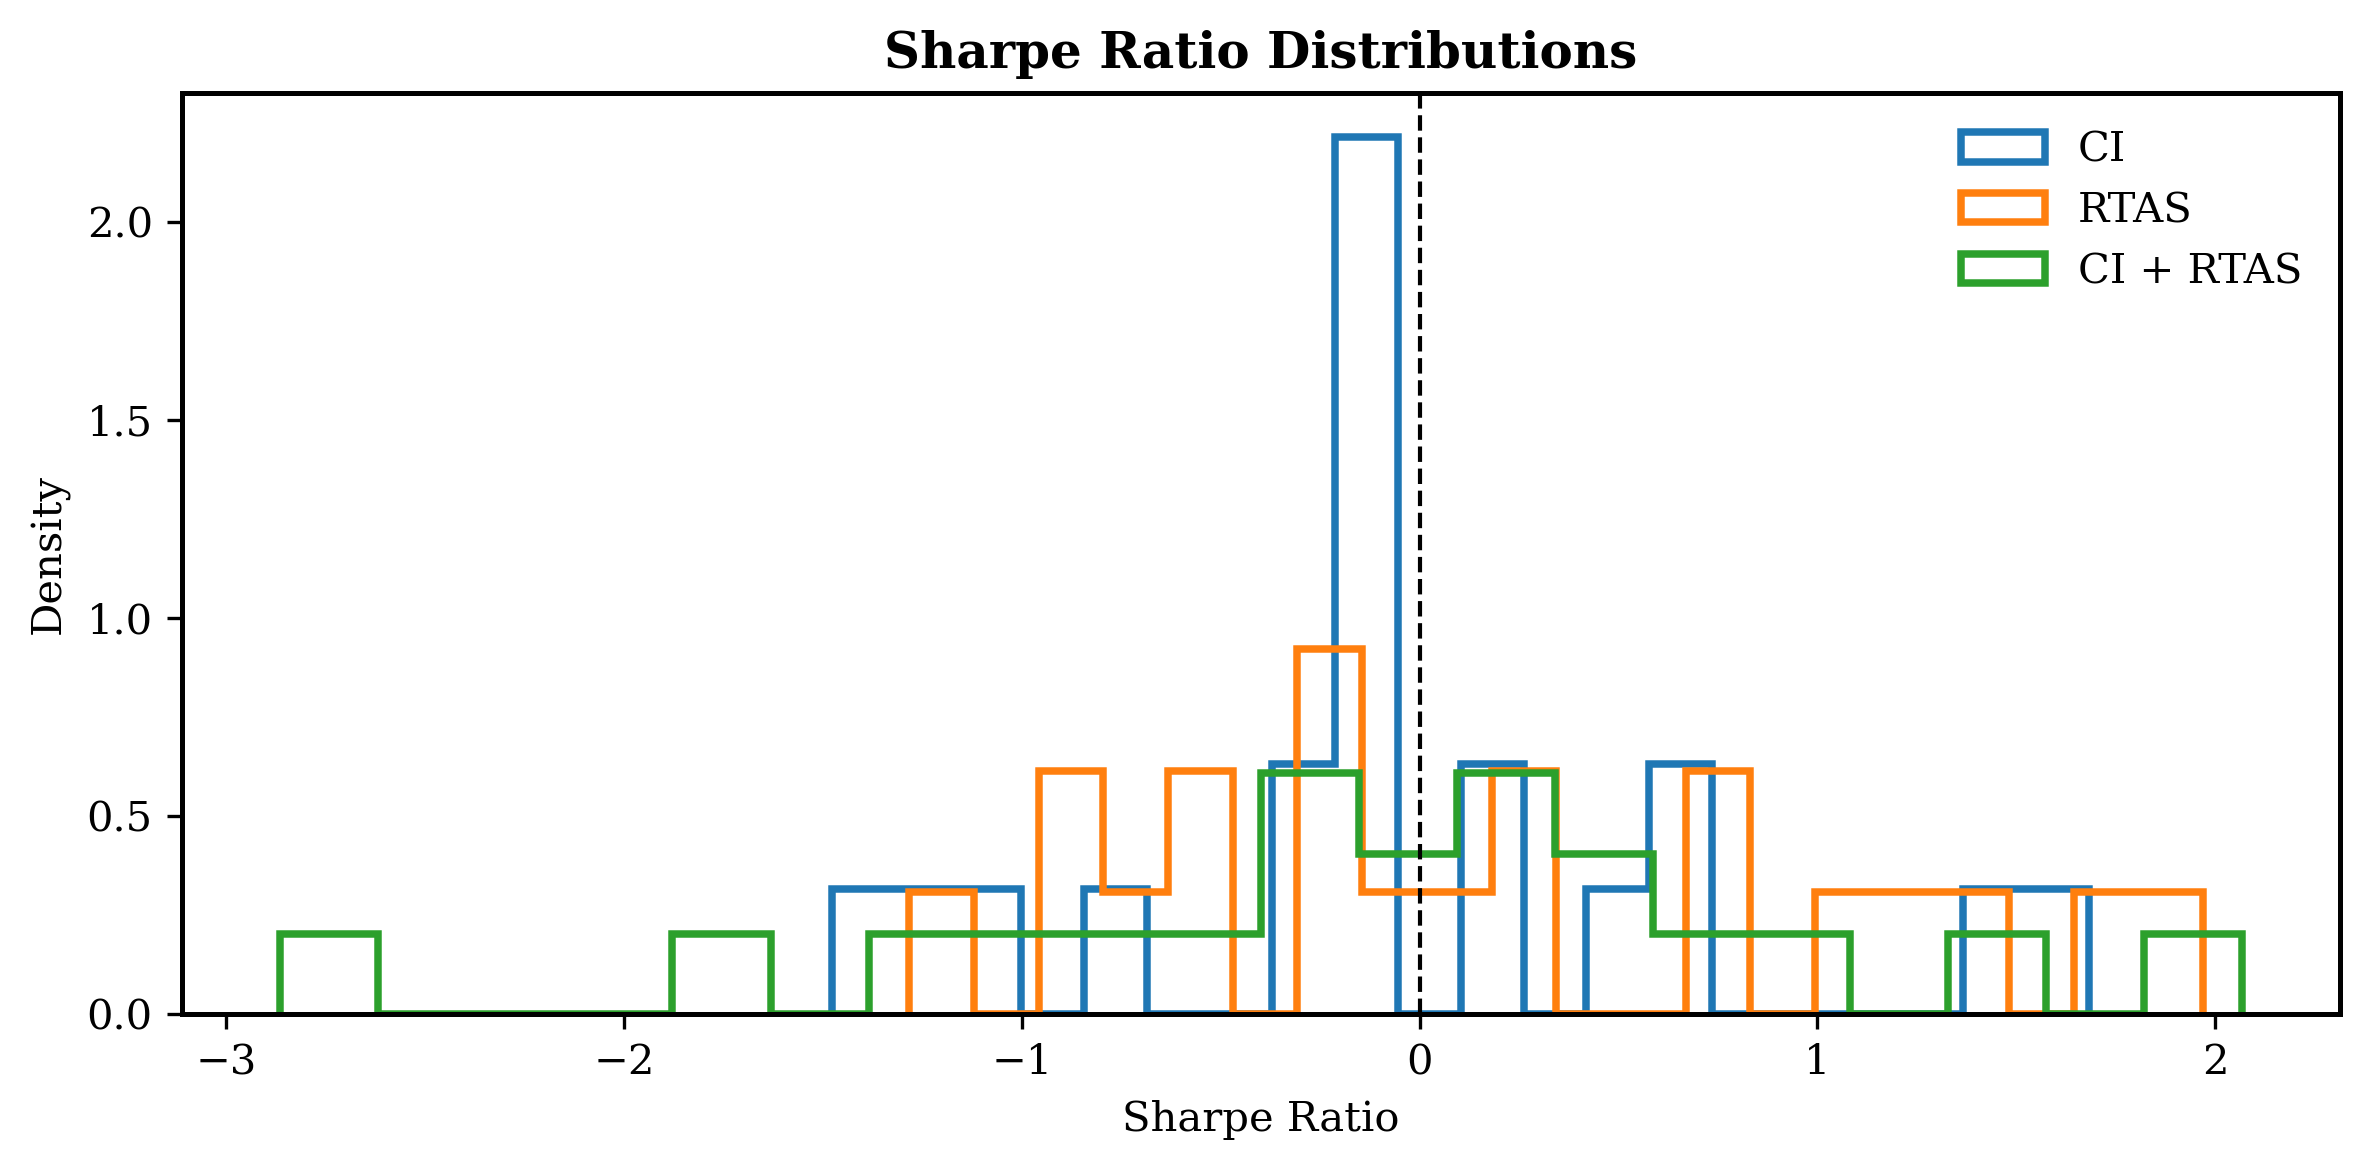

----------------------------------------------------------------------------------------------------
Commods
mean
TI_Sharpe Ratio            -0.242228
TI_Sortino Ratio           -0.358300
TI_Max Drawdown            -0.261624
TI_Accuracy                 0.495215
Sig_Sharpe Ratio           -0.130658
Sig_Sortino Ratio          -0.205826
Sig_Max Drawdown           -0.262363
Sig_Accuracy                0.501910
TI_and_Sig_Sharpe Ratio     0.100288
TI_and_Sig_Sortino Ratio    0.154717
TI_and_Sig_Max Drawdown    -0.233497
TI_and_Sig_Accuracy         0.504120
dtype: float64
median
TI_Sharpe Ratio            -0.238021
TI_Sortino Ratio           -0.372762
TI_Max Drawdown            -0.266169
TI_Accuracy                 0.496154
Sig_Sharpe Ratio           -0.117093
Sig_Sortino Ratio          -0.175982
Sig_Max Drawdown           -0.267956
Sig_Accuracy                0.507692
TI_and_Sig_Sharpe Ratio    -0.039681
TI_and_Sig_Sortino Ratio   -0.066203
TI_and_Sig_Max Drawdown    -0.215795
TI_and_Sig_Ac

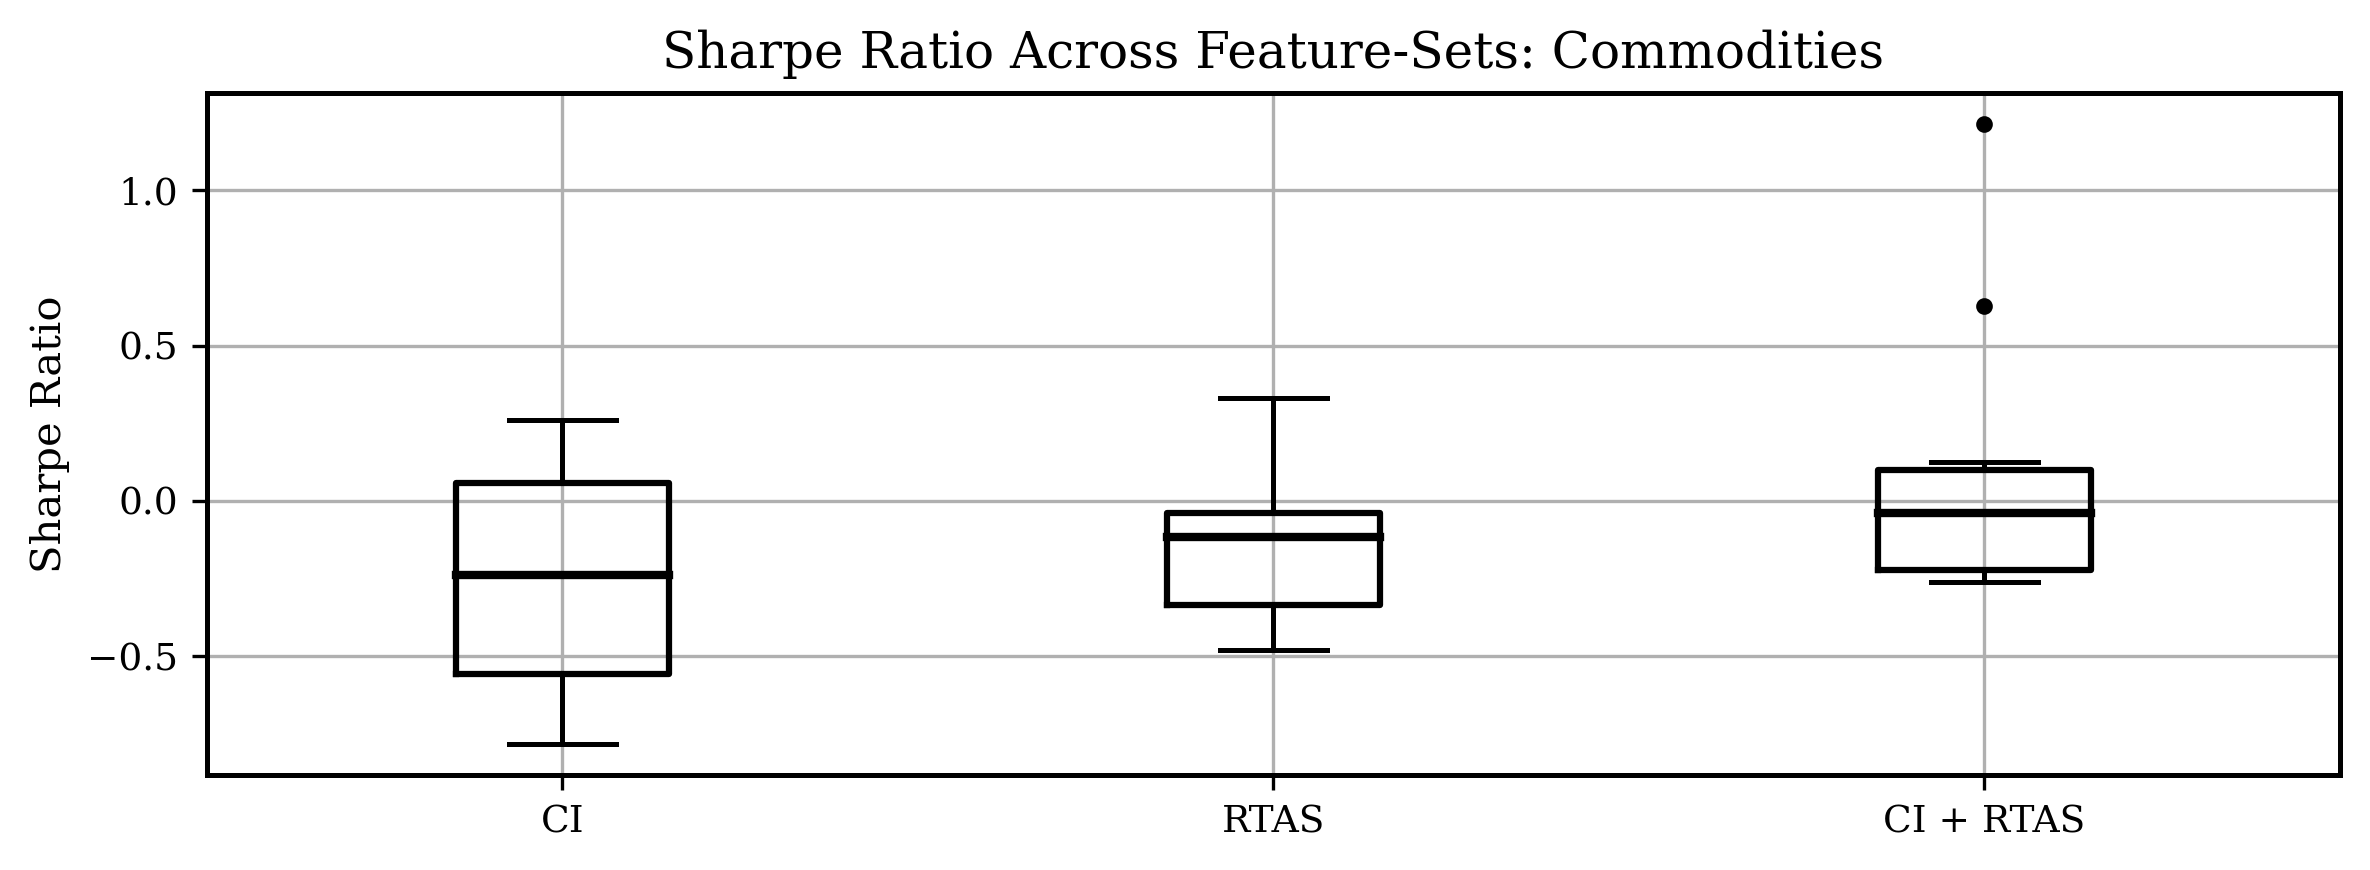

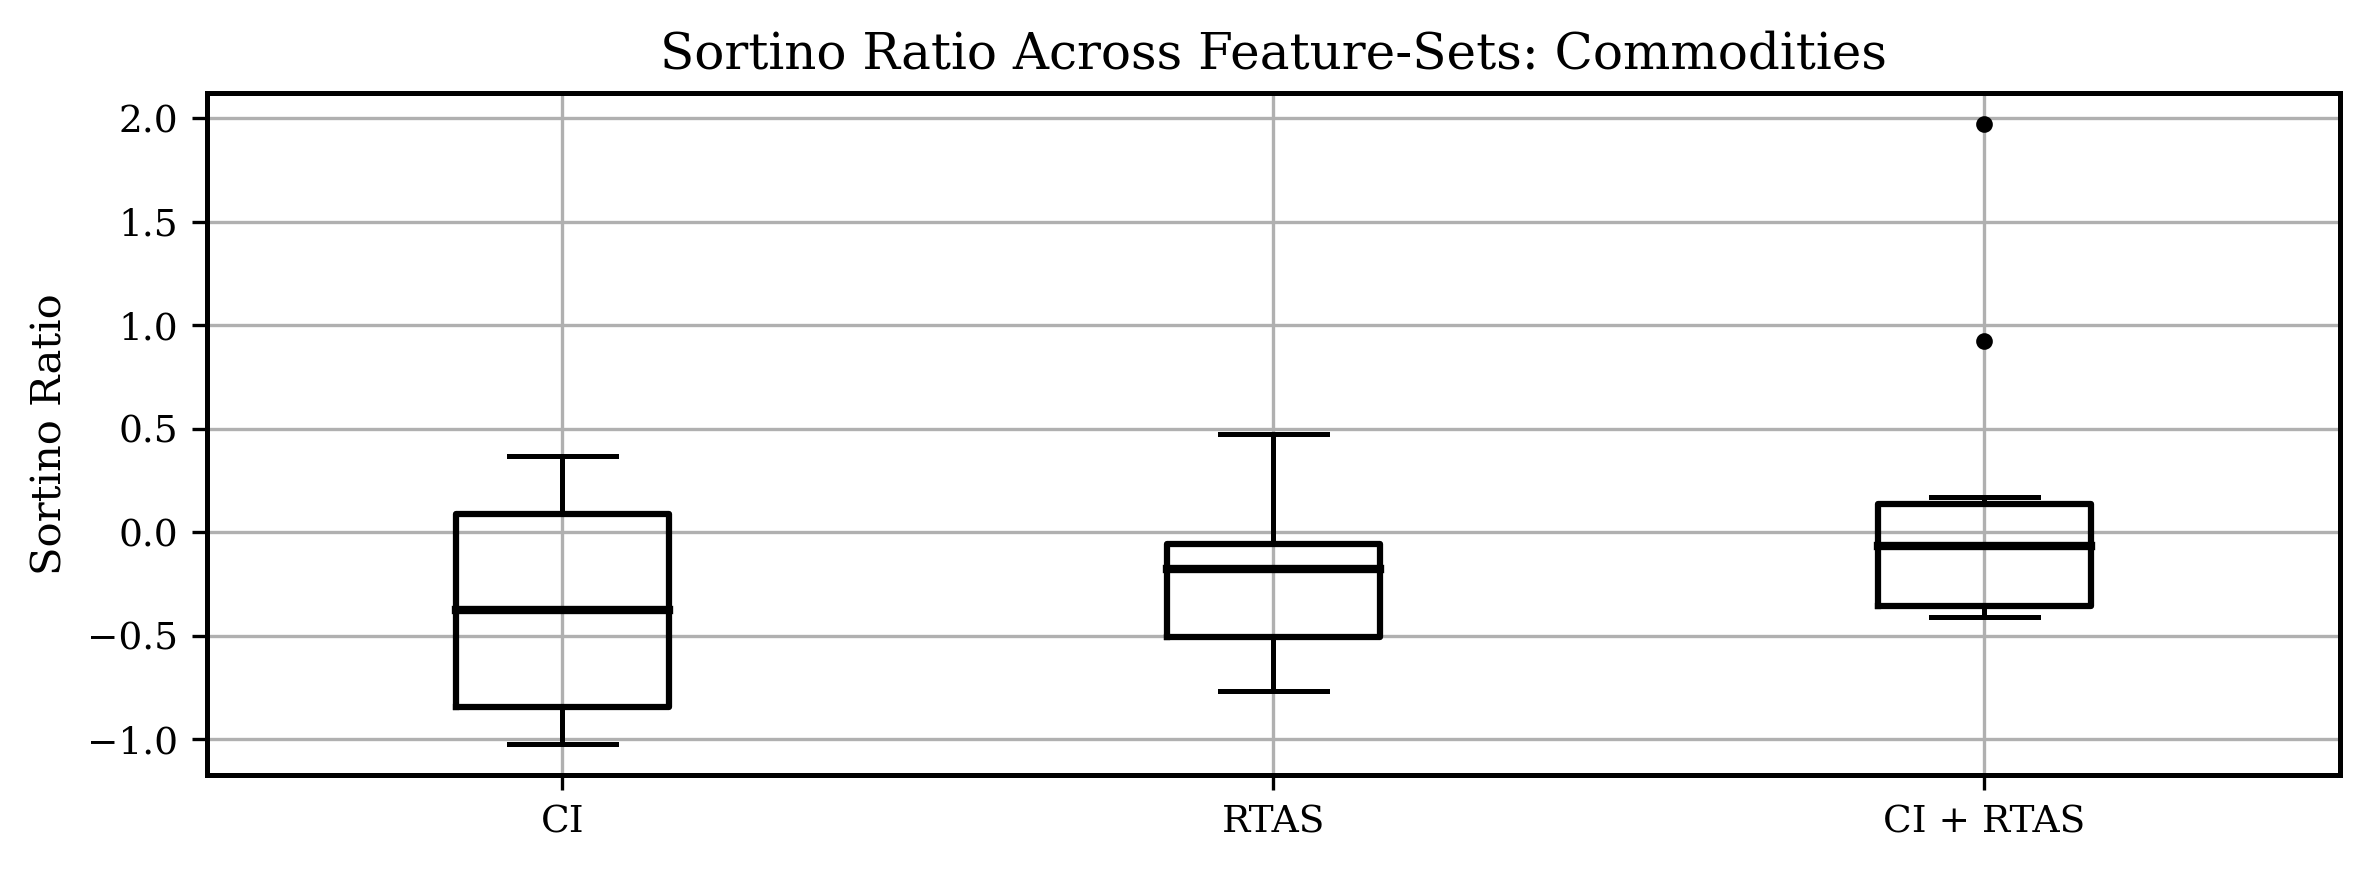

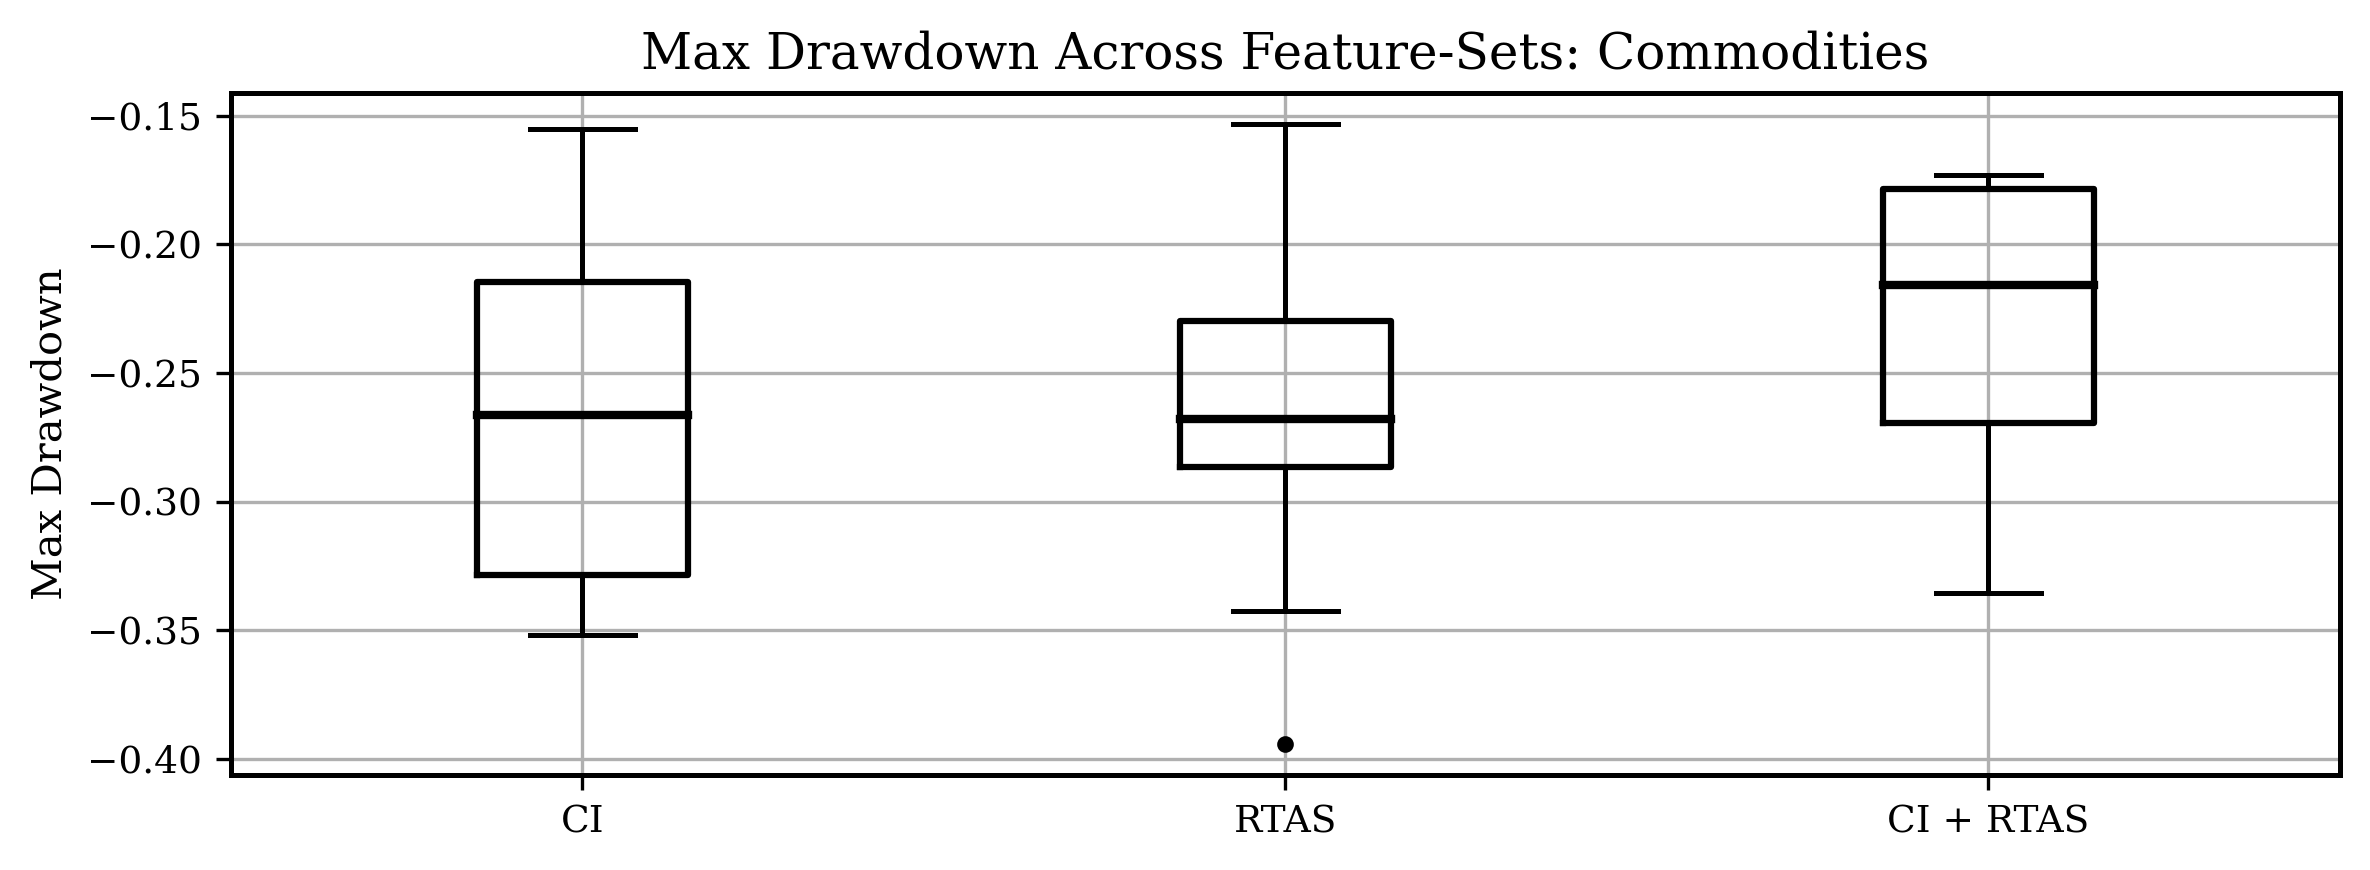

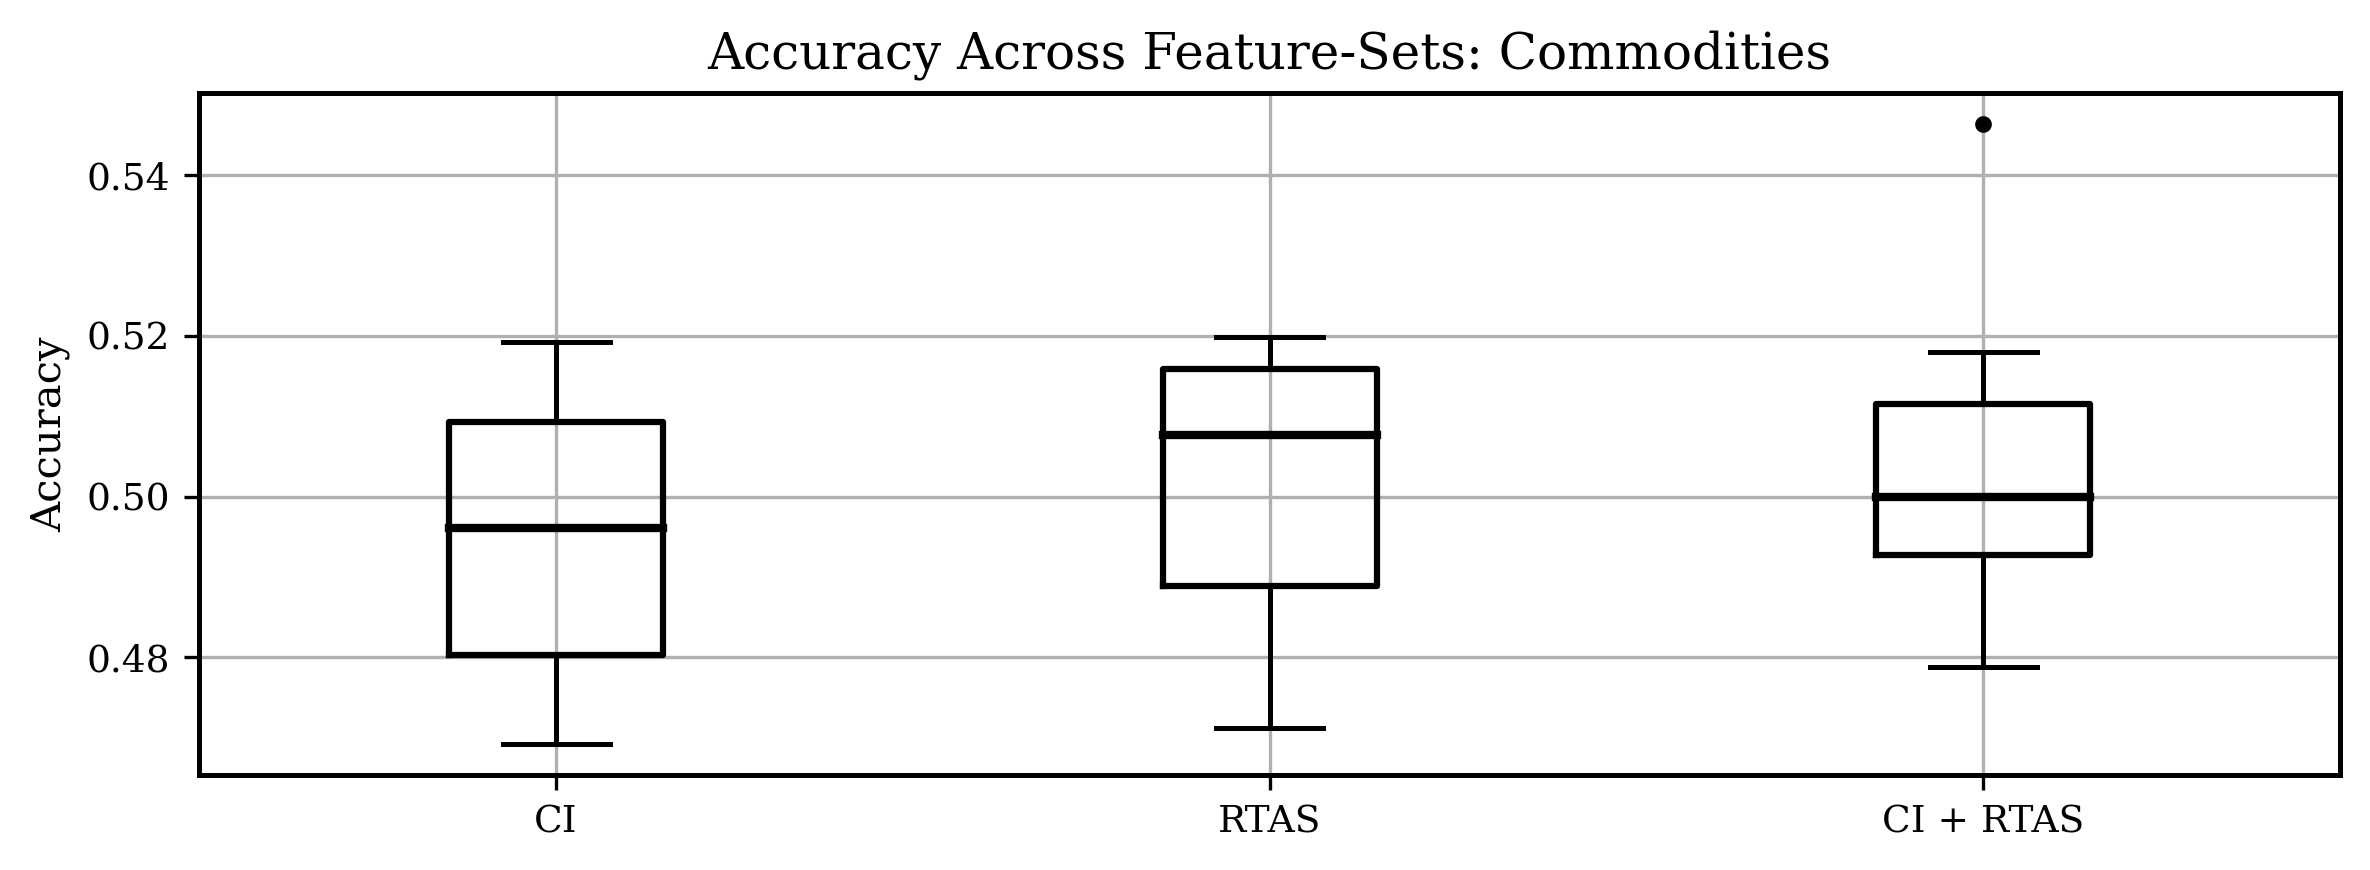

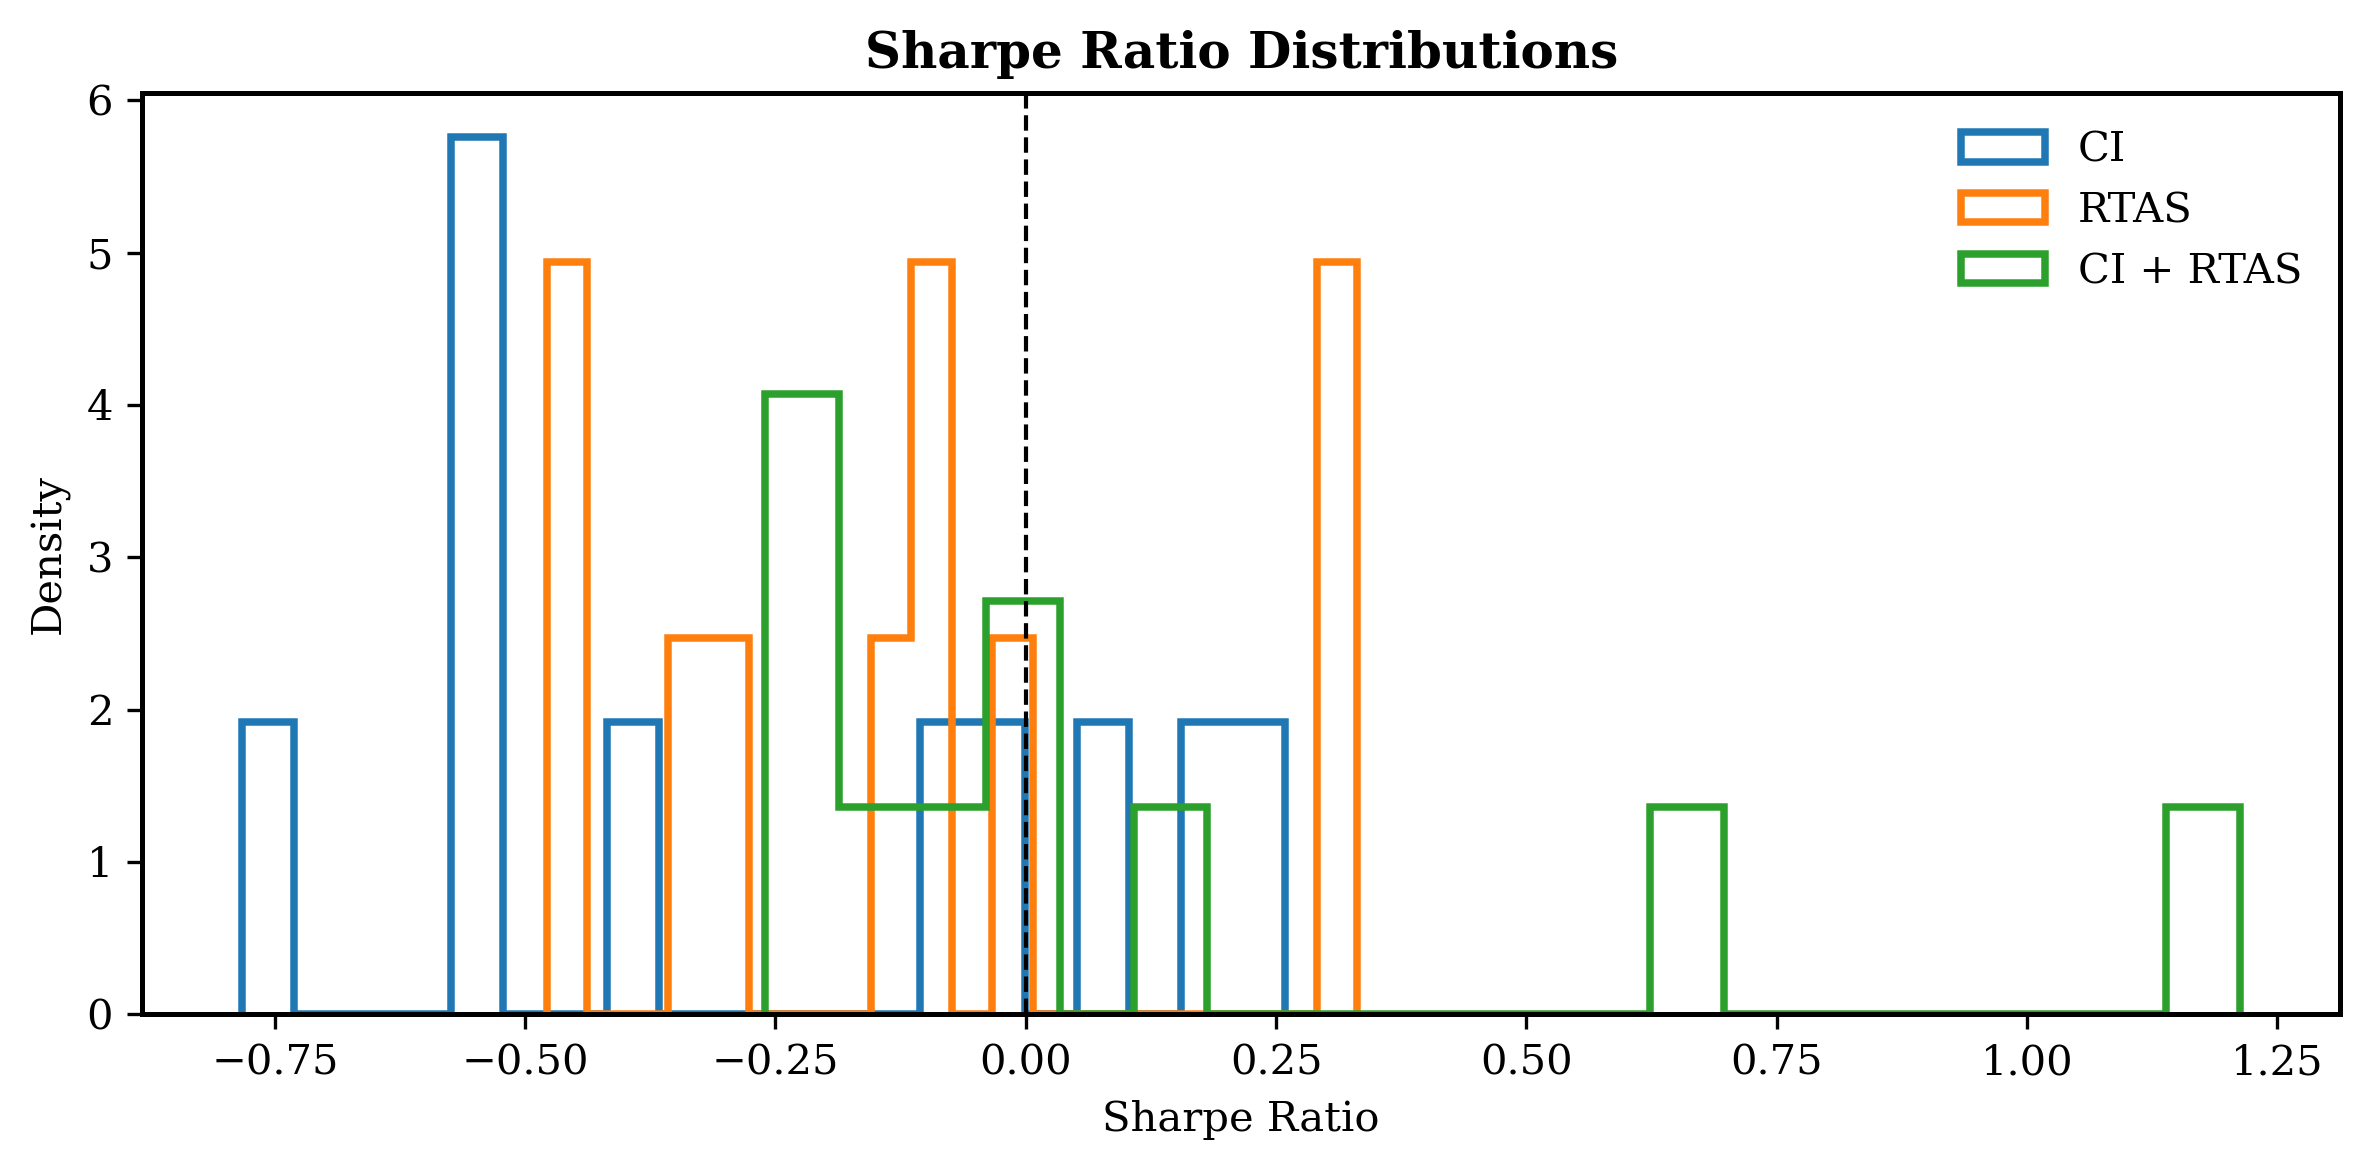

In [26]:
for AssetClass in ['FX', 'Equities', 'Commods']:
    print('-'*100)
    print(AssetClass)

    with open(f'TradingMetricsList_{AssetClass}.pkl', 'rb') as f:
        loaded_list = pickle.load(f)

    df_expanded = CleanMetricsAndSummarise(loaded_list)
    print('mean')
    print(df_expanded.mean(axis=0))
    print('median')
    print(df_expanded.median(axis=0))
    
    # Filter only Sharpe Ratio columns
    sharpe_cols = df_expanded.filter(like='Sharpe Ratio')

    # Count number of positive Sharpe Ratios per column
    positive_sharpe_counts = (sharpe_cols > 0).sum()

    print("Number of Positive Sharpe Ratios per Model:")
    print(positive_sharpe_counts*100/df_expanded.shape[0])
    
    if AssetClass == 'Commods':
        AssetClass = 'Commodities'
    
    PlotBox(df_expanded)
    PlotHist(df_expanded)

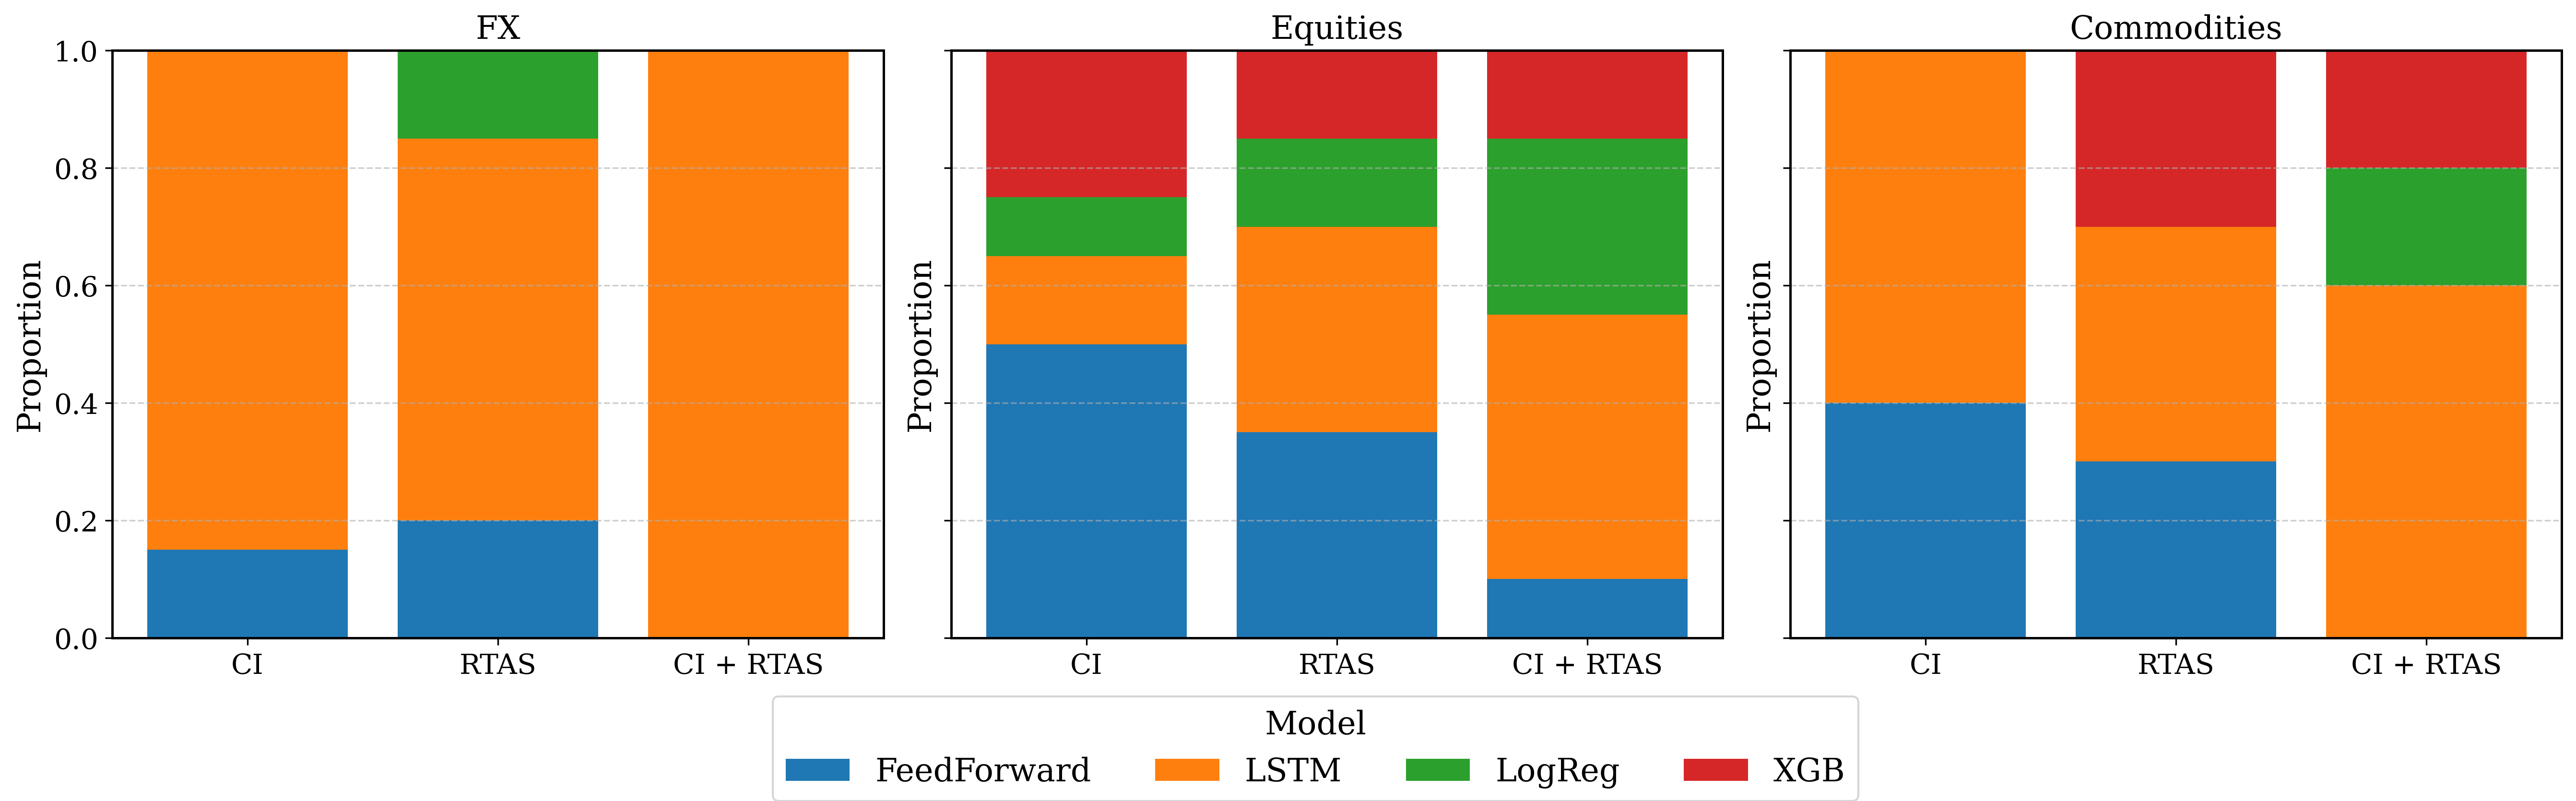

In [29]:
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt

# Modified CountModels to take an axis
def CountModels(data, ax, title):
    # Step 1: Count model occurrences per feature set
    counts = defaultdict(lambda: defaultdict(int))
    all_models = set()

    for entry in data:
        for feature_set, (model, _) in entry.items():
            counts[feature_set][model] += 1
            all_models.add(model)

    feature_sets = ['TI', 'Sig', 'TI_and_Sig']
    model_list = sorted(all_models)
    proportions = {model: [] for model in model_list}

    for fs in feature_sets:
        total = sum(counts[fs].values())
        for model in model_list:
            prop = counts[fs][model] / total if total > 0 else 0
            proportions[model].append(prop)

    x = range(len(feature_sets))
    bottom = [0] * len(feature_sets)

    for model in model_list:
        ax.bar(x, proportions[model], bottom=bottom, label=model)
        bottom = [i + j for i, j in zip(bottom, proportions[model])]

    feature_sets = ['CI', 'RTAS', 'CI + RTAS']
    ax.set_xticks(x)
    ax.set_xticklabels(feature_sets, fontsize=14)
    ax.set_ylim(0, 1)
    ax.set_ylabel("Proportion", fontsize=16)
    ax.set_title(title, fontsize=16)
    ax.tick_params(axis='y', labelsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

# Main plotting logic
asset_classes = ['FX', 'Equities', 'Commods']
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, asset_class in enumerate(asset_classes):
    with open(f'BestModelsList_{asset_class}.pkl', 'rb') as f:
        model_list = pickle.load(f)
        
    if asset_class == 'Commods':
        asset_class = 'Commodities'
    CountModels(model_list, ax=axes[i], title=asset_class)

# Get legend handles and labels from all subplots
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, title="Model", loc=(0.3,0), ncol=len(labels), fontsize=16, title_fontsize=16)


# Adjust layout to make space for legend
plt.tight_layout(rect=[0, 0.1, 1, 0.92])  # Leave space at bottom for legend and top for suptitle
plt.show()

AG


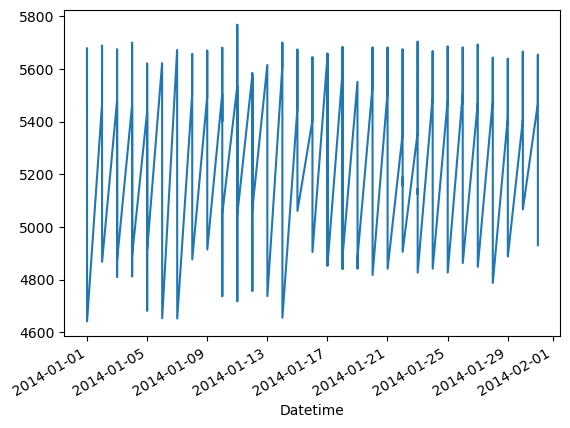

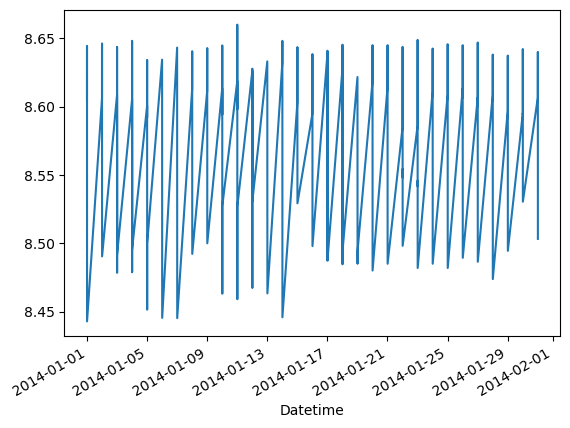

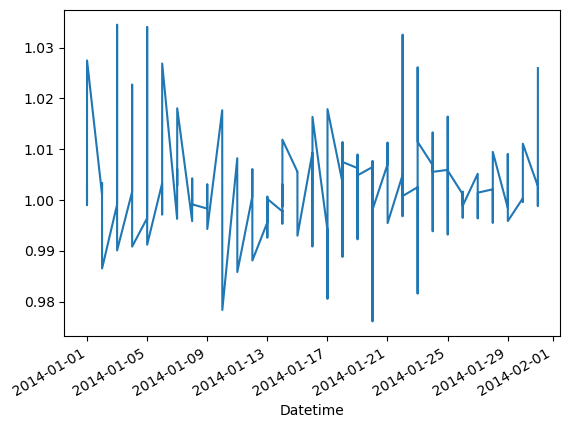

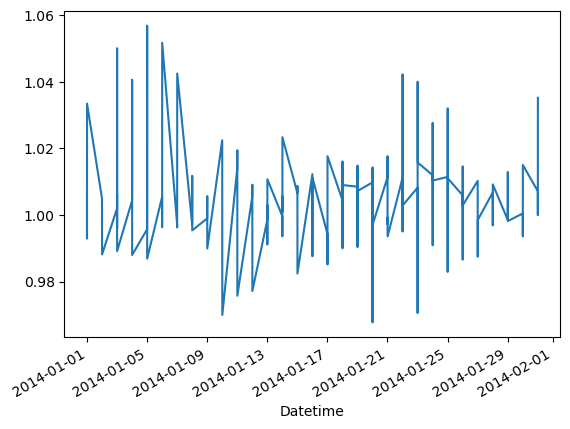

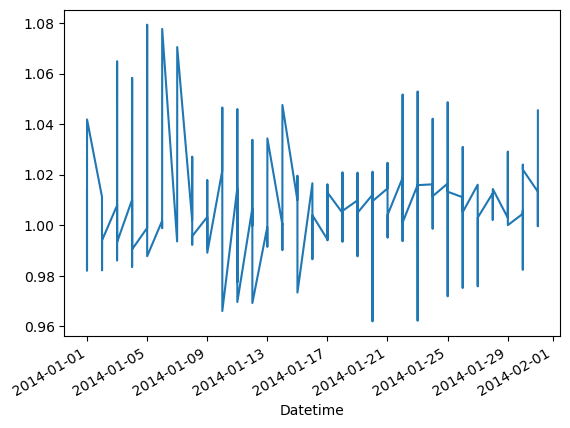

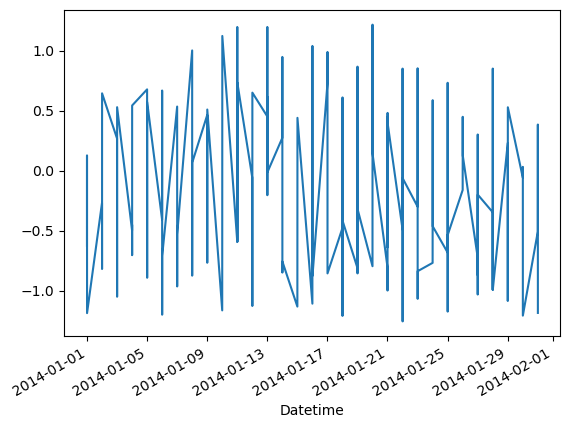

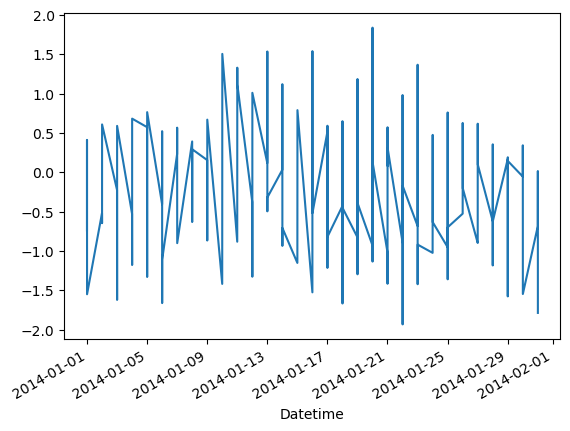

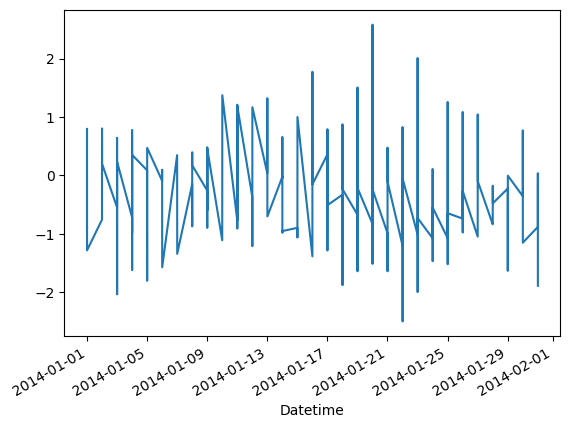

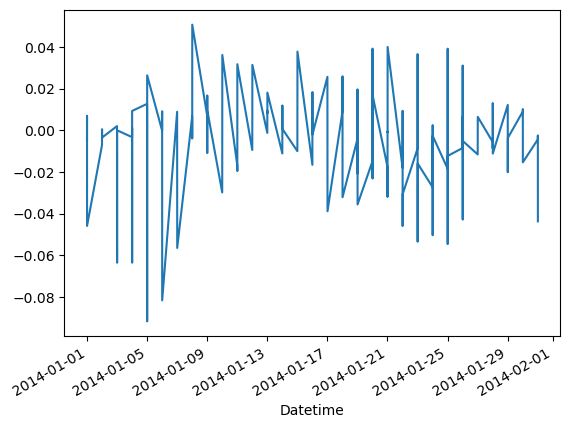

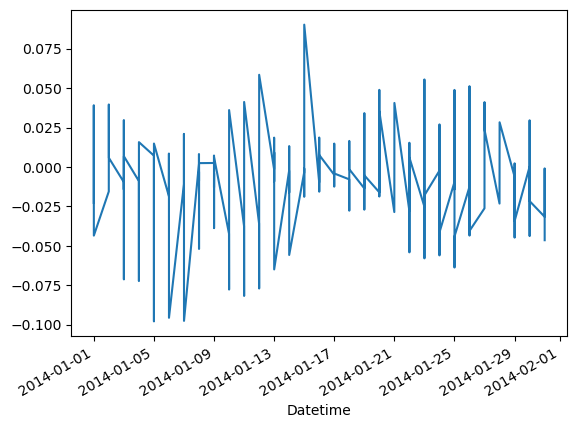

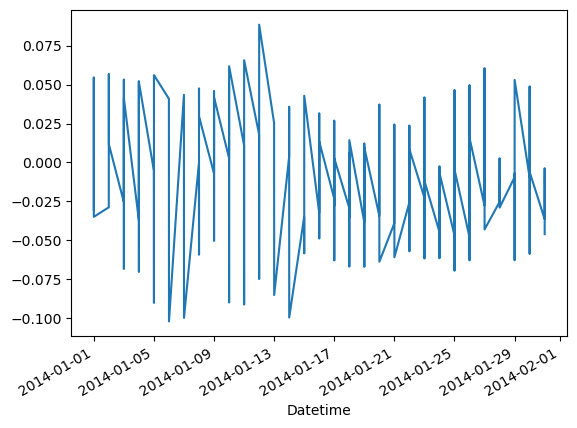

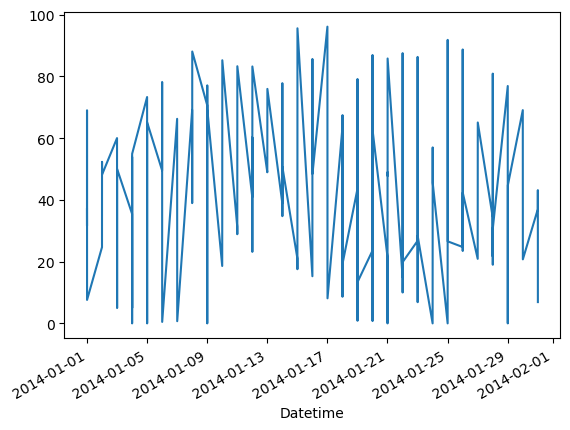

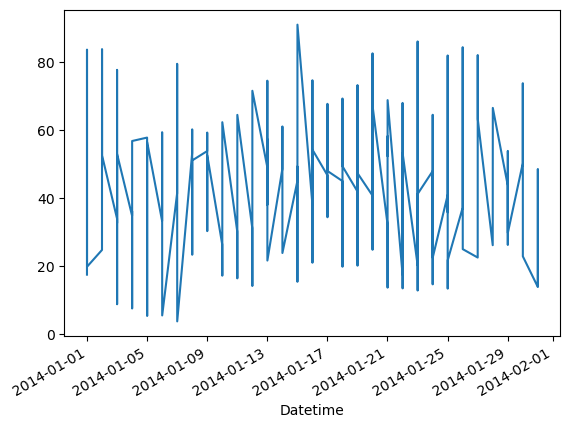

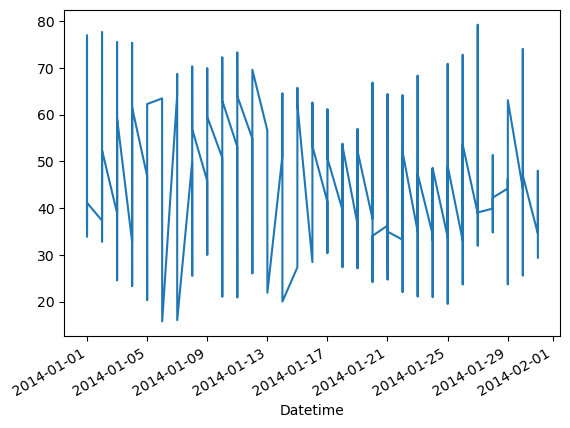

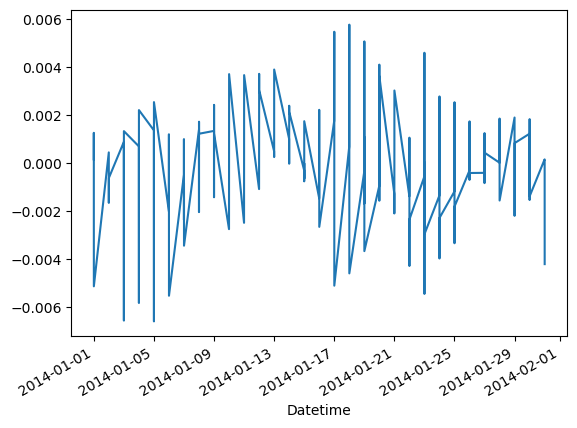

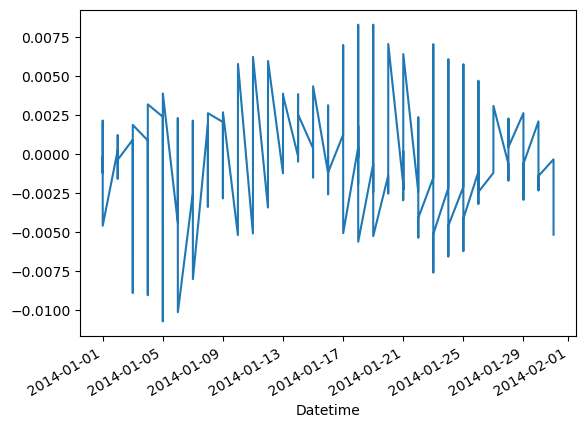

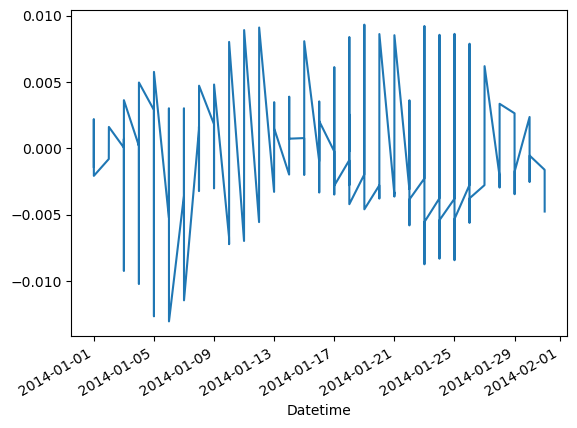

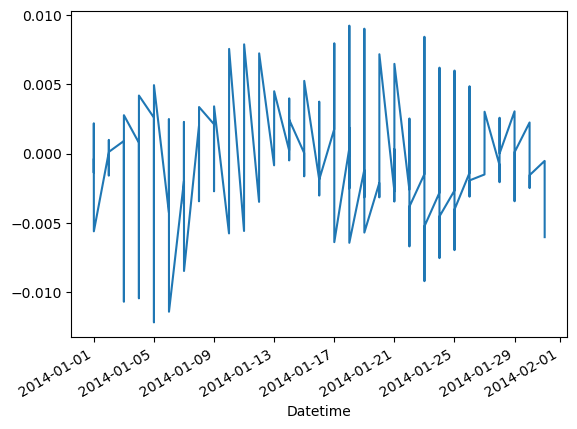

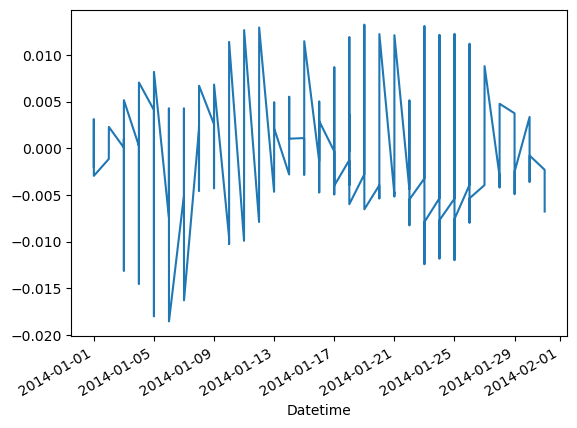

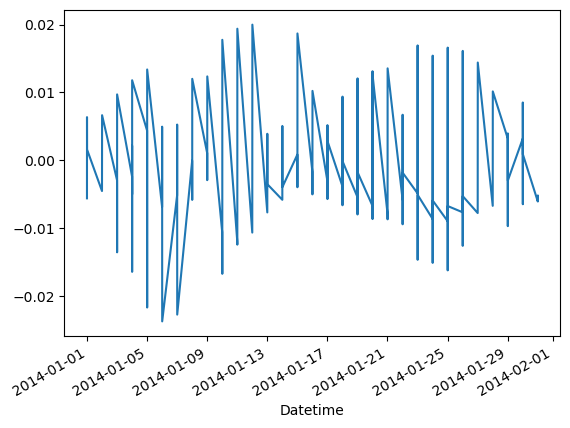

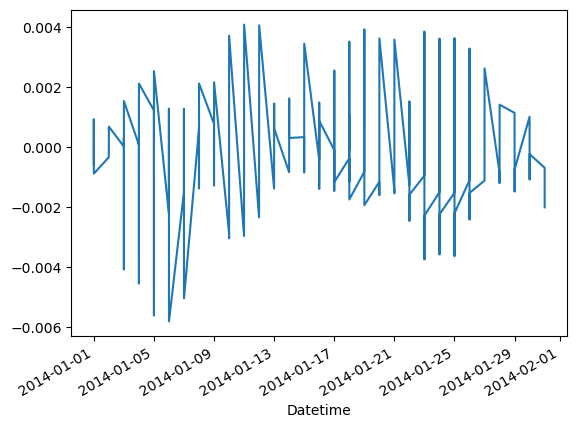

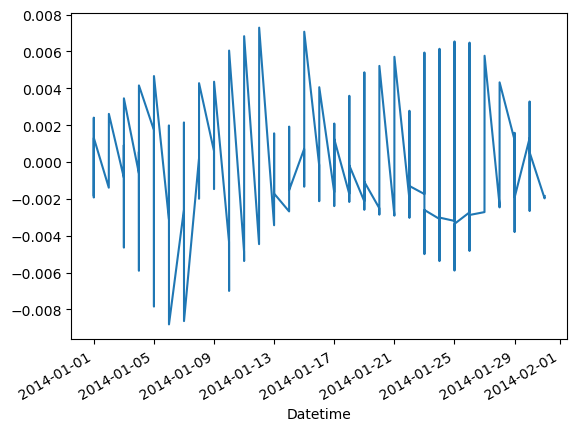

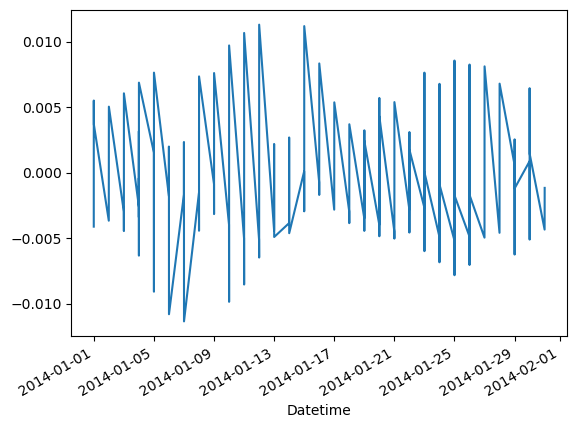

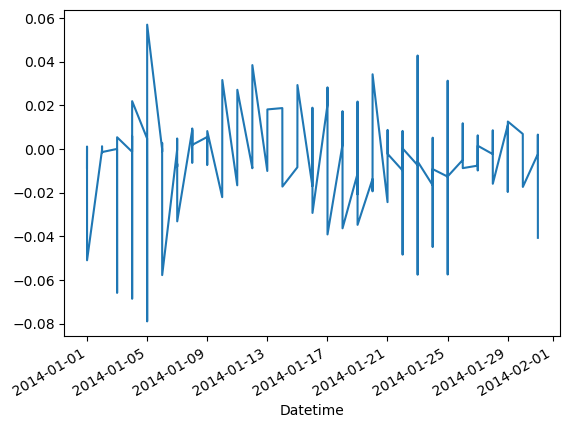

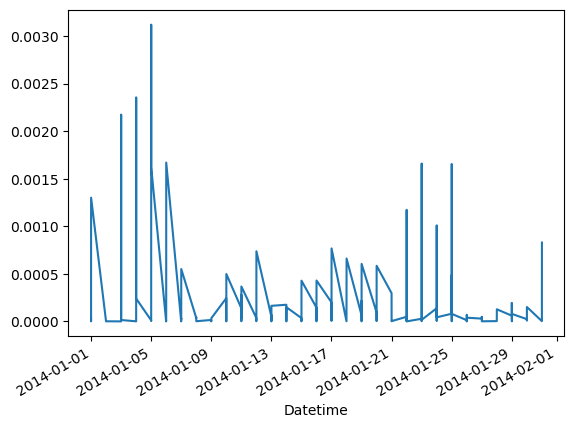

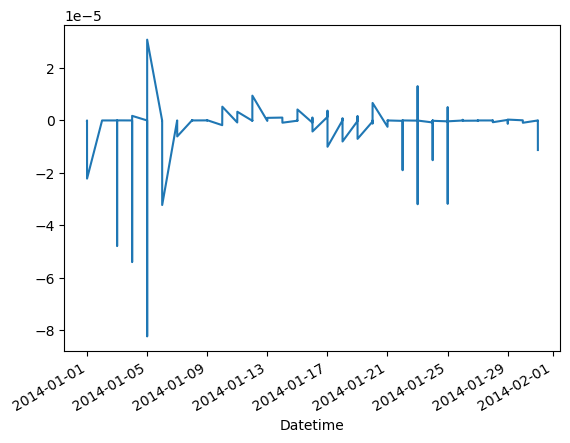

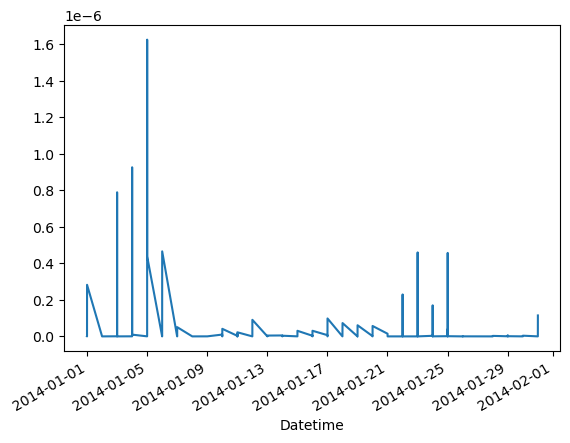

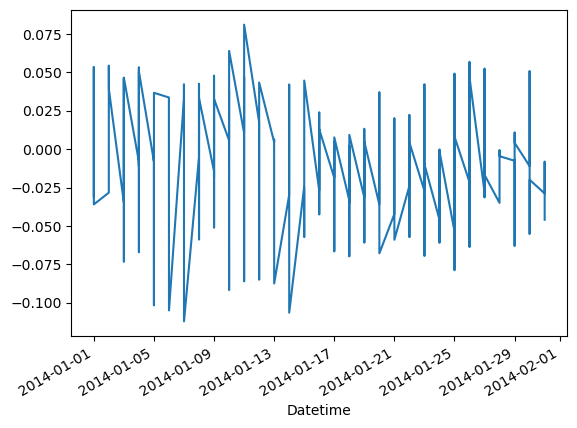

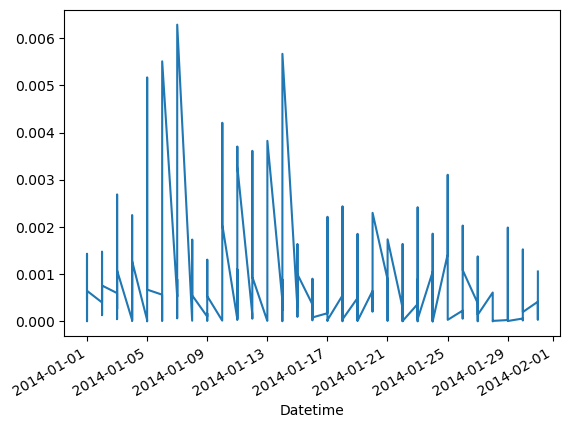

In [20]:
print(asset_name)

for i in range(29):

    df_features.iloc[:200, i].plot()
    plt.show()